In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 
from sklearn.metrics import mean_absolute_percentage_error
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import SVG
IPythonConsole.ipython_useSVG=True
%matplotlib inline 

# Проект по предсказанию характеристики связывания малых молекул с лекарственной мишенью. (Связываемость с рецепторами дофамина)

https://www.kaggle.com/datasets/bhawakshi/pec50-prediction-dopamine-receptor?resource=download&select=enriched_dopamine_ec50.csv  
Отсюда был взял датасет

Состоит из четрых частей: 
1) Построение регресионной модели основанной на отпечатках моргана для предсказания значений pEC50
2) Построение регресионной модели основанной на дескрипторах RDKit для того же предсказания (без и с работой с полученными дескрипторами)
3) Построение классификатора по типам допаминовых рецепторов (Target Name) на отпечатках моргана
4) Построение классификатора основанного на дескрипторах RDKit 


# Подготовка датасета 

Экспериментальные данные: Значения EC50 (нМ), значения pEC50 (-lg(EC50)).

Тип анализа(Assay Type) и название мишени (Target Name): Воспроизводимость и подтип рецептора - D1, D2, D3, D4 и D5.

LogP (липофильность): Указывает на гидрофобность.

H_Donors и H_Acceptors: Показатели способности к водородным связям.

TPSA (топологическая площадь полярной поверхности): Важна для биодоступности.

Количество колец (Ring_Count) и количество вращающихся связей (Rotatable_Bonds): Показатели сложности молекулы.

EC50 - или полумаксимальная эффективная концентрация, означает концентрацию лиганда, которая вызывает эффект, равный половине максимального возможного для данного лиганда после истечения некоторого промежутка времени. 

In [2]:
df = pd.read_csv('enriched_dopamine_ec50.csv')
df = df.drop(['ChEMBL ID'],axis=1)
df

,SMILES,EC50 (nM),Assay Type,Target Name,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,237.00,F,Dopamine D1 receptor,6.625252,315.369,2.29020,3.0,5.0,84.94,3.0,4.0
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,142.00,F,Dopamine D1 receptor,6.847712,223.272,1.44890,3.0,4.0,75.71,2.0,2.0
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,13.60,F,Dopamine D1 receptor,7.866461,279.380,3.00930,3.0,4.0,75.71,2.0,6.0
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,12.50,F,Dopamine D1 receptor,7.903090,315.413,2.88330,3.0,4.0,61.72,3.0,4.0
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,34.40,F,Dopamine D1 receptor,7.463442,285.343,2.28160,3.0,4.0,75.71,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,28.80,B,Dopamine D5 receptor,7.540608,385.467,4.28530,0.0,5.0,56.89,5.0,2.0
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,3981.07,B,Dopamine D5 receptor,5.400000,326.470,1.77042,4.0,4.0,118.42,1.0,8.0
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,34673.69,B,Dopamine D5 receptor,4.460000,541.475,2.12360,6.0,7.0,205.91,1.0,8.0
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,11220.18,B,Dopamine D5 receptor,4.950000,561.465,2.13360,6.0,7.0,205.91,2.0,6.0


In [3]:
df.describe()

,EC50 (nM),pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
count,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000,3125.000000
mean,2418.908740,7.118945,384.084779,3.641346,1.283520,4.512960,58.772669,3.705920,6.068800
std,9995.496686,1.291602,111.162887,1.391528,1.183378,1.829542,30.400569,1.189306,4.150969
min,0.000480,4.000000,138.122000,-1.129200,0.000000,1.000000,3.240000,1.000000,0.000000
25%,8.600000,6.221849,326.470000,2.755480,1.000000,3.000000,41.570000,3.000000,3.000000
50%,66.070000,7.179996,384.476000,3.638100,1.000000,4.000000,54.040000,4.000000,6.000000
75%,600.000000,8.065502,435.355000,4.468400,2.000000,5.000000,66.480000,4.000000,8.000000
max,100000.000000,12.318759,1721.165000,12.094200,21.000000,19.000000,562.340000,12.000000,55.000000


Посмотрим на распределение потенциального таргета:

In [4]:
df['pEC50'].value_counts()

pEC50
5.000000    240
6.000000     42
4.000000     25
5.500000     25
8.000000     18
           ... 
7.269218      1
5.836004      1
6.592949      1
6.148986      1
4.620000      1
Name: count, Length: 1346, dtype: int64

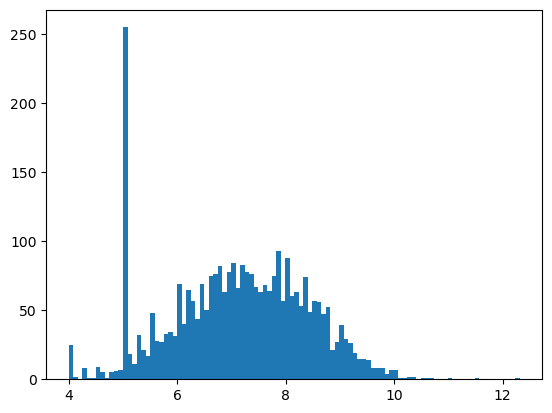

In [5]:
ax = plt.hist(df['pEC50'], bins=100)

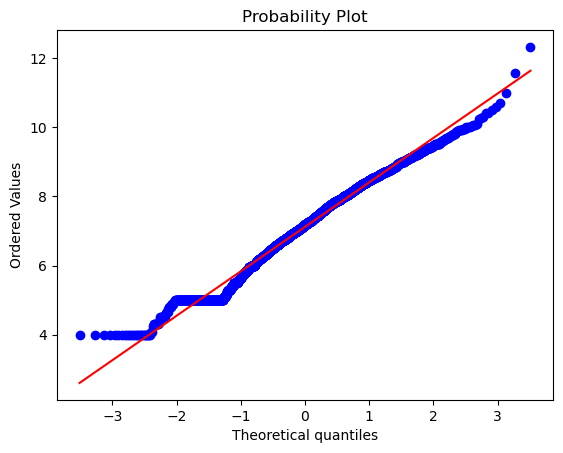

In [6]:
import pylab 
import scipy.stats as stats
stats.probplot(df['pEC50'], dist="norm", plot=pylab)
pylab.show()

Как видно из гистограммы выше, значения pEC50 = 5 и 4 являются довольно очевидными выбросами, что довольно просто объясняется тем, что в статьях значение 5 часто выбирают в качестве порога, то есть приближения, оно не отражает действительное значение pEC50
qq plot Также показывает, что наш будущих таргет распрелен не нормально и есть выбросы

In [7]:
df_u = df[(df['pEC50']!=5) & (df['pEC50']!=4)]
df_u

,SMILES,EC50 (nM),Assay Type,Target Name,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,237.00,F,Dopamine D1 receptor,6.625252,315.369,2.29020,3.0,5.0,84.94,3.0,4.0
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,142.00,F,Dopamine D1 receptor,6.847712,223.272,1.44890,3.0,4.0,75.71,2.0,2.0
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,13.60,F,Dopamine D1 receptor,7.866461,279.380,3.00930,3.0,4.0,75.71,2.0,6.0
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,12.50,F,Dopamine D1 receptor,7.903090,315.413,2.88330,3.0,4.0,61.72,3.0,4.0
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,34.40,F,Dopamine D1 receptor,7.463442,285.343,2.28160,3.0,4.0,75.71,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,28.80,B,Dopamine D5 receptor,7.540608,385.467,4.28530,0.0,5.0,56.89,5.0,2.0
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,3981.07,B,Dopamine D5 receptor,5.400000,326.470,1.77042,4.0,4.0,118.42,1.0,8.0
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,34673.69,B,Dopamine D5 receptor,4.460000,541.475,2.12360,6.0,7.0,205.91,1.0,8.0
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,11220.18,B,Dopamine D5 receptor,4.950000,561.465,2.13360,6.0,7.0,205.91,2.0,6.0


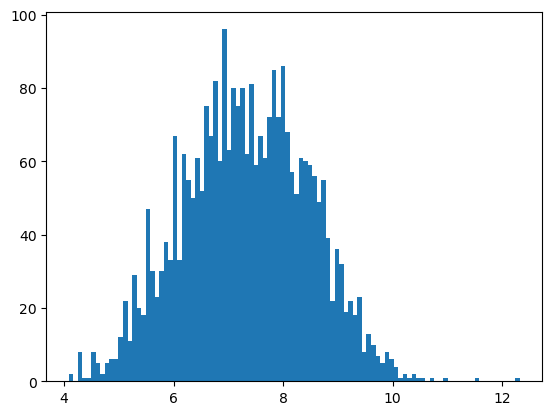

In [8]:
ax = plt.hist(df_u['pEC50'], bins=100)

Дополнитель проведем квартильную фильтрацию

In [9]:
Q1 = df_u['pEC50'].quantile(0.2)
Q3 = df_u['pEC50'].quantile(0.8)
IQR = Q3 - Q1
filtered_df =  df_u[~((df_u['pEC50'] < (Q1 - 1.5 * IQR)) |(df_u['pEC50'] > (Q3 + 1.5 * IQR)))]
filtered_df

,SMILES,EC50 (nM),Assay Type,Target Name,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,237.00,F,Dopamine D1 receptor,6.625252,315.369,2.29020,3.0,5.0,84.94,3.0,4.0
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,142.00,F,Dopamine D1 receptor,6.847712,223.272,1.44890,3.0,4.0,75.71,2.0,2.0
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,13.60,F,Dopamine D1 receptor,7.866461,279.380,3.00930,3.0,4.0,75.71,2.0,6.0
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,12.50,F,Dopamine D1 receptor,7.903090,315.413,2.88330,3.0,4.0,61.72,3.0,4.0
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,34.40,F,Dopamine D1 receptor,7.463442,285.343,2.28160,3.0,4.0,75.71,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,28.80,B,Dopamine D5 receptor,7.540608,385.467,4.28530,0.0,5.0,56.89,5.0,2.0
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,3981.07,B,Dopamine D5 receptor,5.400000,326.470,1.77042,4.0,4.0,118.42,1.0,8.0
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,34673.69,B,Dopamine D5 receptor,4.460000,541.475,2.12360,6.0,7.0,205.91,1.0,8.0
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,11220.18,B,Dopamine D5 receptor,4.950000,561.465,2.13360,6.0,7.0,205.91,2.0,6.0


Построим qq plot чтобы сравнить наше распределение с нормальным более наглядно:

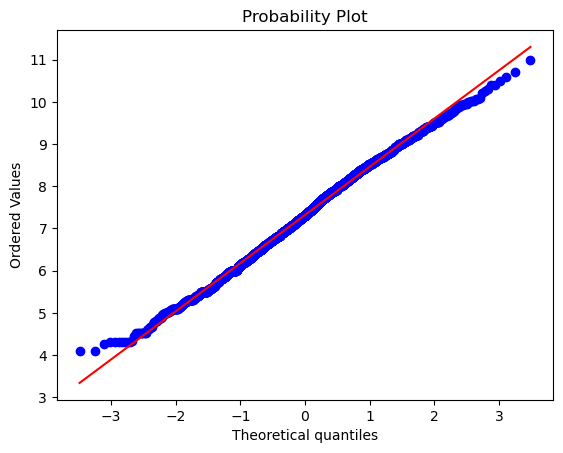

In [10]:
import pylab 
import scipy.stats as stats
stats.probplot(filtered_df['pEC50'], dist="norm", plot=pylab)
pylab.show()

Распределение теперь выглядит хорошо, можно работать дальше

In [11]:
df_work = filtered_df[['SMILES','EC50 (nM)','pEC50']]
df_work

,SMILES,EC50 (nM),pEC50
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,237.00,6.625252
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,142.00,6.847712
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,13.60,7.866461
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,12.50,7.903090
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,34.40,7.463442
...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,28.80,7.540608
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,3981.07,5.400000
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,34673.69,4.460000
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,11220.18,4.950000


Посмотрим на распределение таргета в случае -лог() и простой формы:

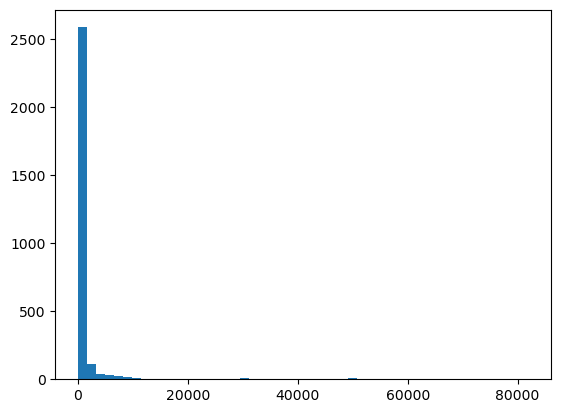

In [12]:
ax = plt.hist(df_work['EC50 (nM)'], bins=50)

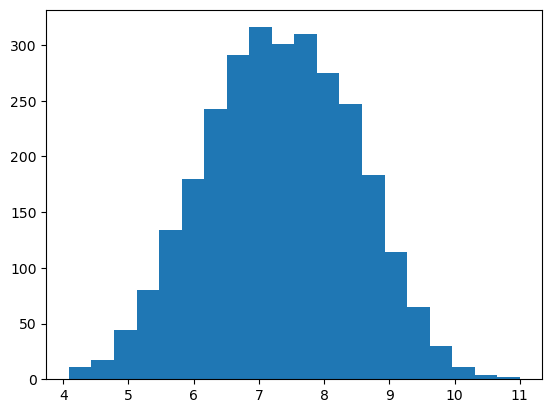

In [13]:
ax = plt.hist(df_work['pEC50'], bins=20)

Очевидно, что распределение таргета в случае отрицательного логаримфа гораздо ближе к нормальному, будем предсказывать именно его (переменную pEC50)

In [14]:
df_work = df_work.drop('EC50 (nM)',axis=1)
df_work

,SMILES,pEC50
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,6.625252
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,6.847712
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,7.866461
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,7.903090
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,7.463442
...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,7.540608
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,5.400000
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,4.460000
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,4.950000


# Часть 1 

# Добавление отпечатков в рабочий сет

На данный момент стоит выбрать оптимальное значение радиуса и битности:
Для нашей задачи подойдет перебор радиусов в диапазоне от 1 до 3, и битности  512 1024 и 2048.

На всякий случай канонизируем смайлз

In [15]:
df_work['SMILES'] = df_work['SMILES'].apply(lambda x: Chem.CanonSmiles(x))

Добавим столбец с мол-файлами

In [16]:
PandasTools.AddMoleculeColumnToFrame(df_work, smilesCol='SMILES', molCol='Molecule')

,SMILES,pEC50,Molecule
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,6.625252,
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,6.847712,
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,7.866461,
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,7.903090,
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,7.463442,
...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,7.540608,
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,5.400000,
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,4.460000,
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,4.950000,

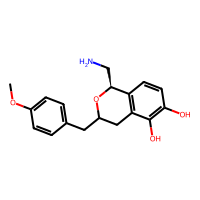
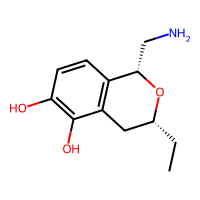
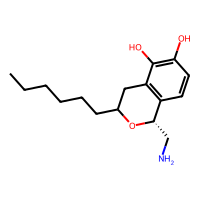
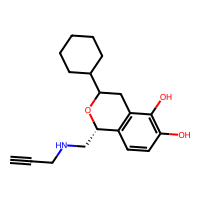
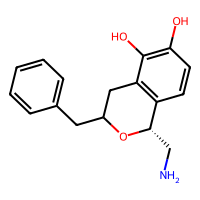
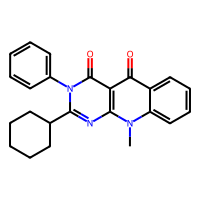
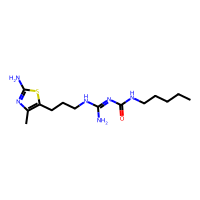
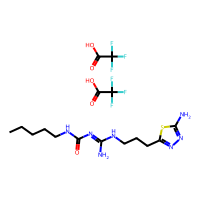
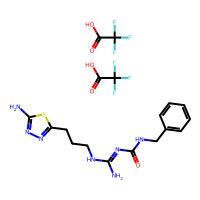
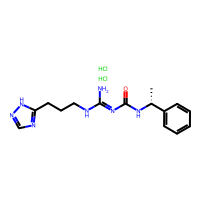

In [17]:
df_work

Добавим разные  отпечатки пальцев

In [18]:
def fpgen(x,n,size):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=n,fpSize=size,includeChirality=True)
    e = mfpgen.GetFingerprint(x)#получаем FP
    return (e) 

,SMILES,pEC50,Molecule,"fp1,512","fp1,1024","fp1,2048","fp2,512","fp2,1024","fp2,2048","fp3,512","fp3,1024","fp3,2048"
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,6.625252,,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,6.847712,,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,7.866461,,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,7.903090,,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,7.463442,,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,7.540608,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,5.400000,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,4.460000,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0,
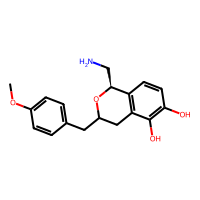
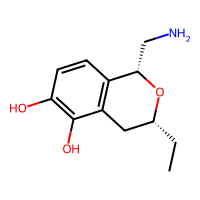
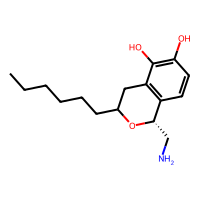
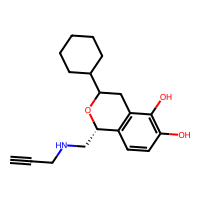
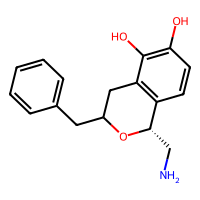
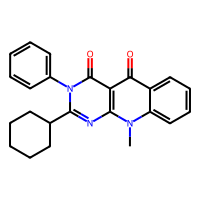
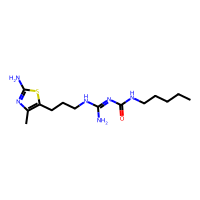
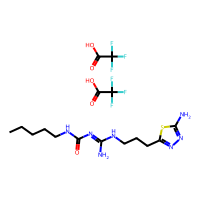
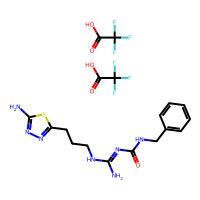
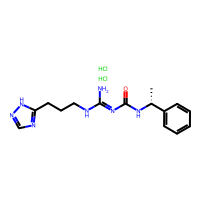

In [19]:
r = [1,2,3]
bit = [512,1024,2048]
for i in r:
    for b in bit:
        df_work[f'fp{i},{b}'] = df_work['Molecule'].apply(lambda x: fpgen(x,i,b))
df_work

Я выберу оптимальное значение радуиса и битности путем использования RandomForestRegressor как показательной модели, после чего уже проведу побор гиперпараметров 

Разбиваем сет на трейн и тест с самого начала

In [20]:
X = df_work.drop(['SMILES','pEC50','Molecule'],axis=1)
y = df_work['pEC50']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

In [21]:
params = {
    "n_estimators": 100,
    "max_depth": 15,
    "min_samples_split": 2,'min_samples_leaf': 1 
,'random_state':13}

Здесь я включил режим программиста и решил написать код который будет перебирать все типы отпечатков и смотреть эффективность регресионной модели добавляя в конечный список значение r2 и название столбца (конечно я мог 9 раз запустить код, но это было бы не так круто :)

In [22]:
col = X_train.columns
r2_l = []
for c in col:
    e = np.ones(shape=(512,))
    e2= np.ones(shape=(1024,))
    e3= np.ones(shape=(2048,))
    d = np.ones(shape=(512,))
    d2= np.ones(shape=(1024,))
    d3= np.ones(shape=(2048,))    
    
    for fp in X_train[c]:
        if len(np.array(fp)) == 512:
            e = np.vstack((e,np.array(fp)))
        elif len(np.array(fp)) == 1024:
            e2 = np.vstack((e2,np.array(fp)))
        elif len(np.array(fp)) == 2048:
            e3 = np.vstack((e3,np.array(fp)))
    
    if  e.shape != (512,):
        e = np.delete(e,0,0)
        Train = e
    elif e2.shape != (1024,):
        e2 = np.delete(e2,0,0)
        Train = e2
    elif e3.shape != (2048,):
        e3 = np.delete(e3,0,0)
        Train = e3

    for fp in X_test[c]:
        if len(np.array(fp)) == 512:
            d = np.vstack((d,np.array(fp)))
        elif len(np.array(fp)) == 1024:
            d2 = np.vstack((d2,np.array(fp)))
        else:
            d3 = np.vstack((d3,np.array(fp)))
    
    if  d.shape != (512,):
        d = np.delete(d,0,0)        
        Test = d
    elif d2.shape != (1024,):
        d2 = np.delete(d2,0,0)         
        Test = d2
    elif d3.shape != (2048,):
        d3 = np.delete(d3,0,0)         
        Test = d3 
    reg = RandomForestRegressor(**params).fit(Train, y_train)
    r2 = r2_score(y_test, reg.predict(Test))
    r2_l.append([c,r2])
    print(r2_l[-1]) 


['fp1,512', 0.29779257777768575]
['fp1,1024', 0.30419548018720477]
['fp1,2048', 0.3040858247358792]
['fp2,512', 0.3083581447547471]
['fp2,1024', 0.3156053151902073]
['fp2,2048', 0.31747427210745216]
['fp3,512', 0.3026695053497994]
['fp3,1024', 0.3174112226736021]
['fp3,2048', 0.3108751115457825]


Из выведенной выше таблицы можно сделать вывод, что оптимальный выбор - это радиус = 2, и битность 2048. Но учитывая значение результата R2 можно начать подозревать, что химическая структура молекулы не является очень хорошим признаком для определения pEC50. 
Но далее мы проверим несколько различных регрисионных моделей, а так же проведем оптимизацию их гиперпараметров

In [23]:
d = np.ones(shape=(2048,))
for fp in X_test['fp2,2048']:
    d = np.vstack((d,np.array(fp)))
d = np.delete(d,0,0)        
Test = d
d = np.ones(shape=(2048,))
for fp in X_train['fp2,2048']:
    d = np.vstack((d,np.array(fp)))
d = np.delete(d,0,0)     
Train = d


# Проведем оптимизацию гиперпараметров для RFR

Сначала воспользуемся RandomizedSearchCV а потом уже GridSearchem

In [24]:
from sklearn.model_selection import RandomizedSearchCV
rfr = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfr, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(Train, y_train)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

После чего строю графики для каждого параметра, где можно будет визуально увидеть лучшие значения

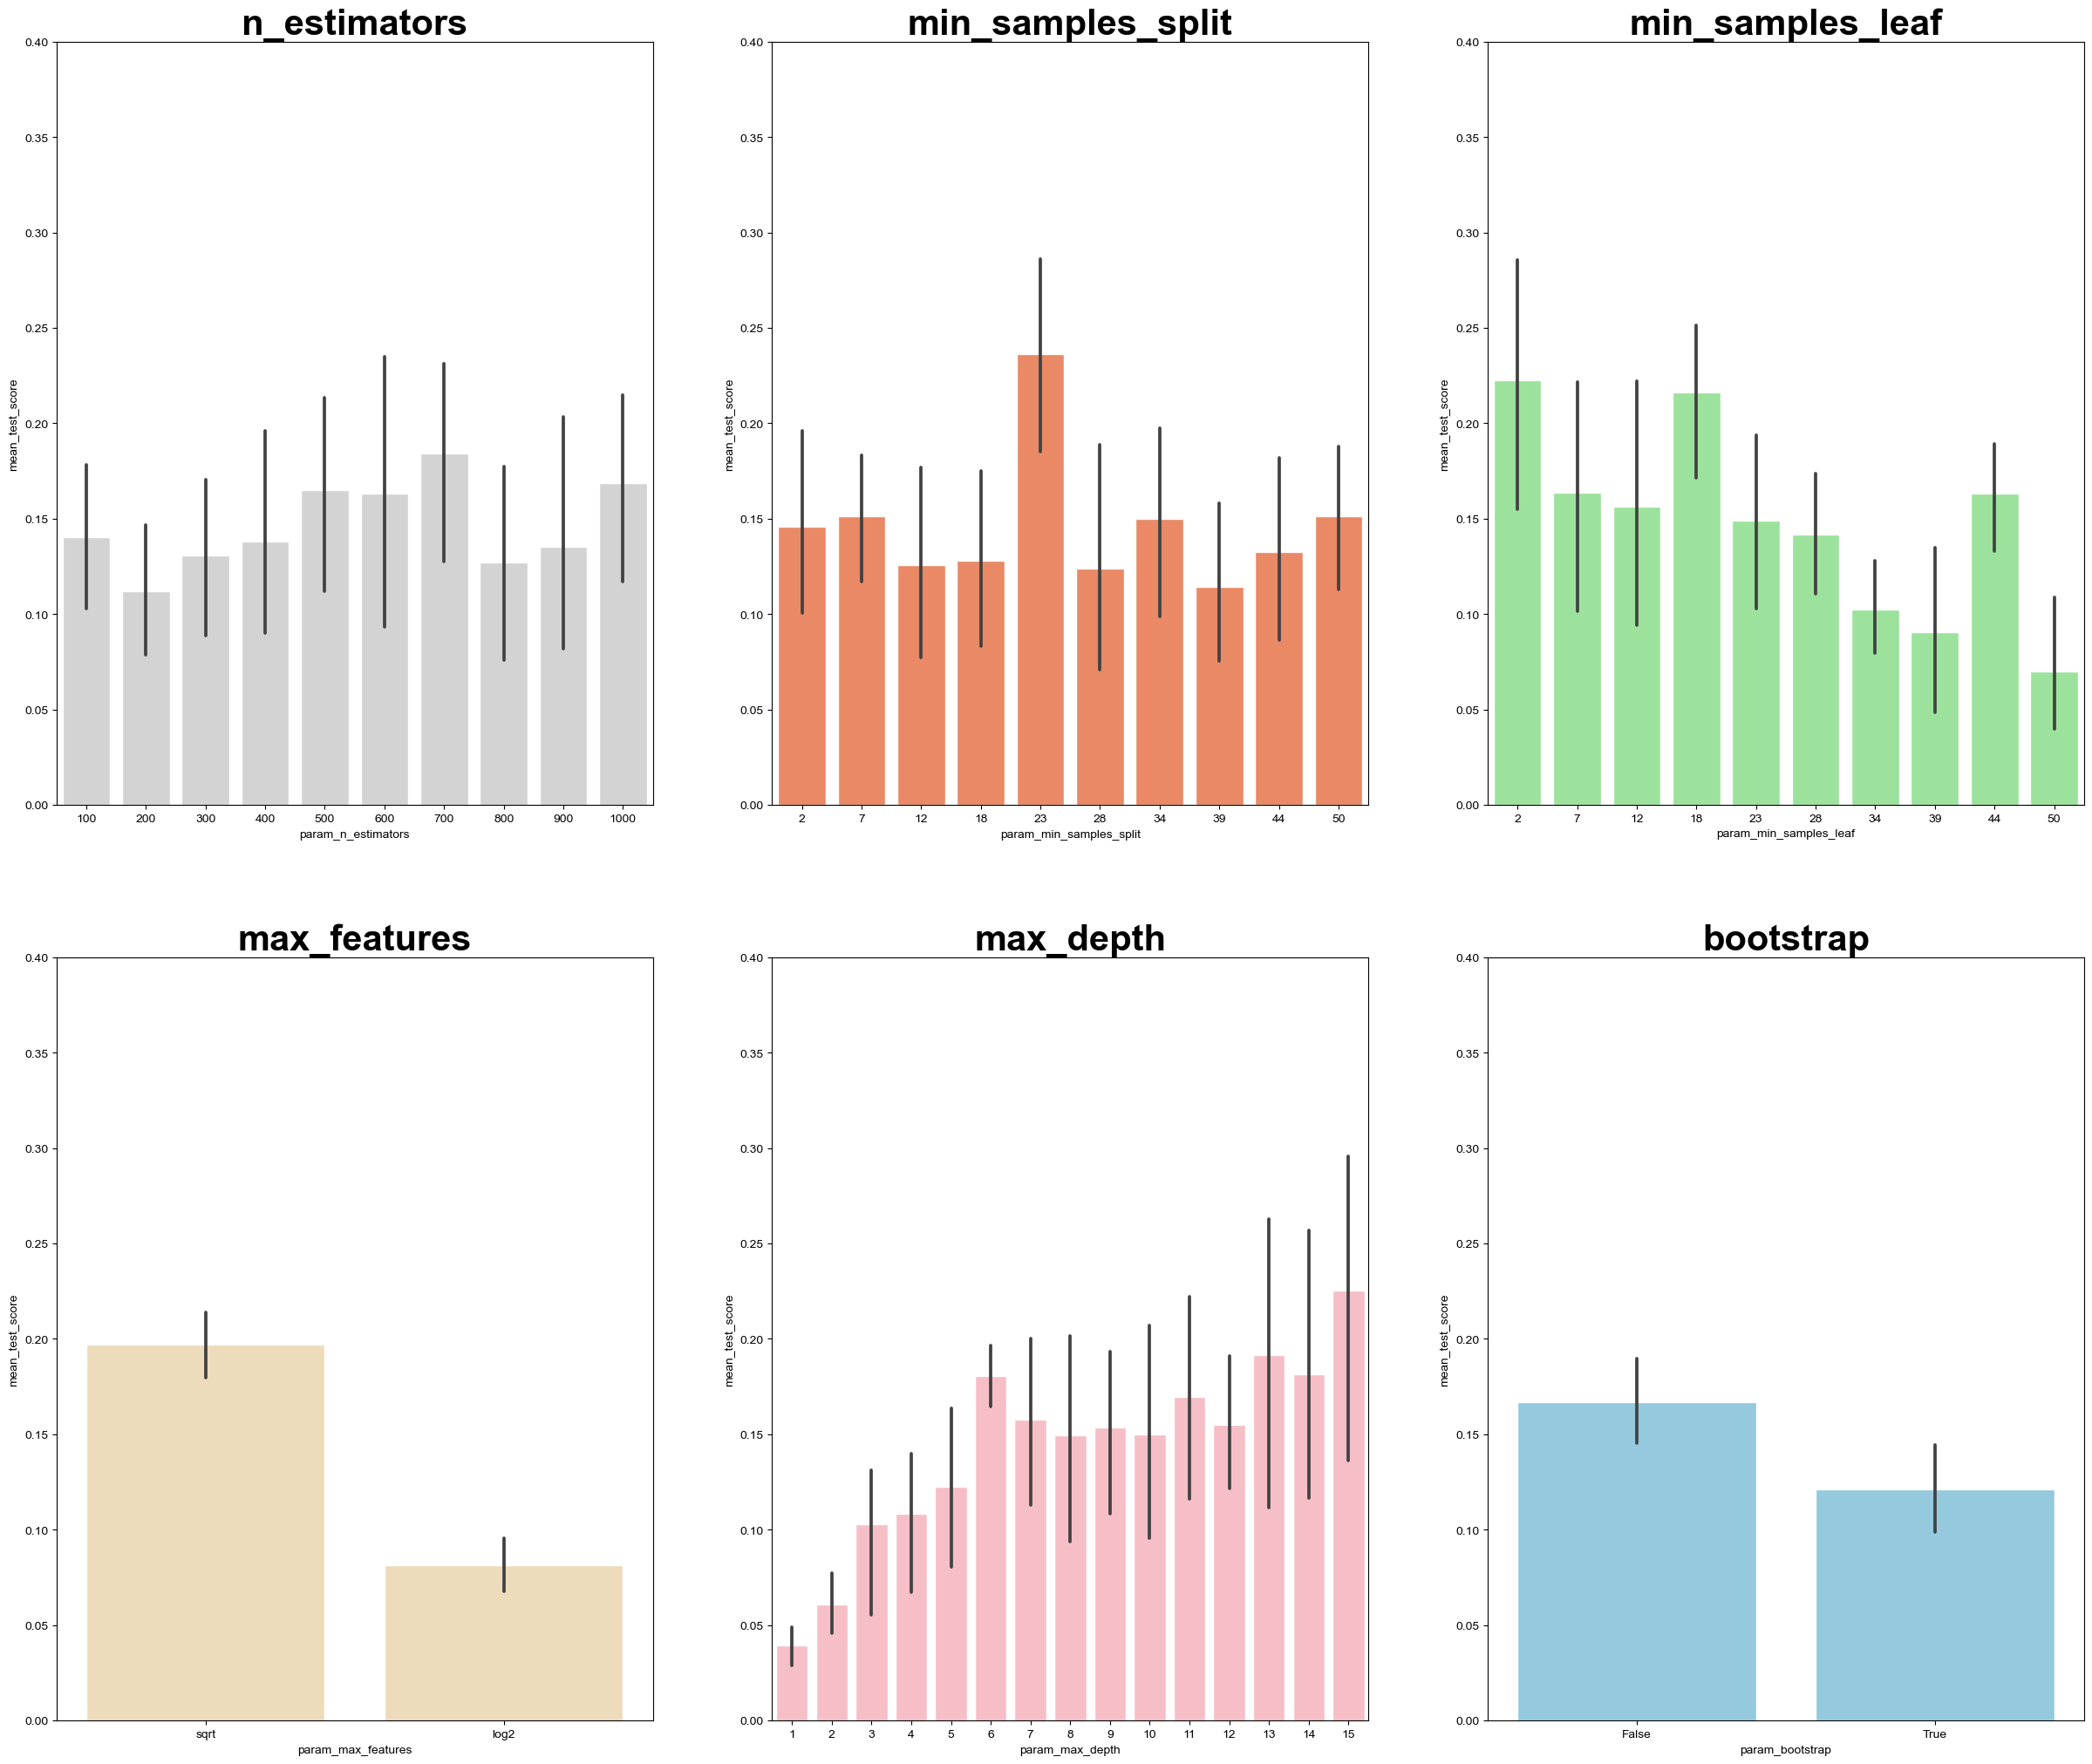

In [25]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot( data=rs_df,x='param_n_estimators', y='mean_test_score', ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([0,0.4])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([0,0.4])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([0,0.4])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([0,0.4])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([0,0.4])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([0,0.4])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()


Далее уже из вручную выбранных значений, с помощью GridSearchCV находим наилучшую комбинацию гиперпараметров для нашей модели

In [26]:
from sklearn.model_selection import GridSearchCV
n_estimators = [500,700]
min_samples_split = [7,23]
min_samples_leaf = [2,18]
max_features = ['sqrt']
max_depth = [6,13,15]
bootstrap = [False,True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfr, param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(Train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 700}

In [27]:
y_pred = gs.best_estimator_.predict(Test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.3154795876046378
Mean squared error: 0.8977141670343255
Mean absolute error: 0.7552310235089378
Mean absolute percentage error: 0.10732010643692687


Модель объясняет 32% дисперсии y, а так же в принципе дает не такой уж плохой результат (далеко не хороший, но не ужасный). При предсказании мы в среднем ошибаемся на 11 процентов.

# Попробуем понизить размерность отпечатков с помощью PCA

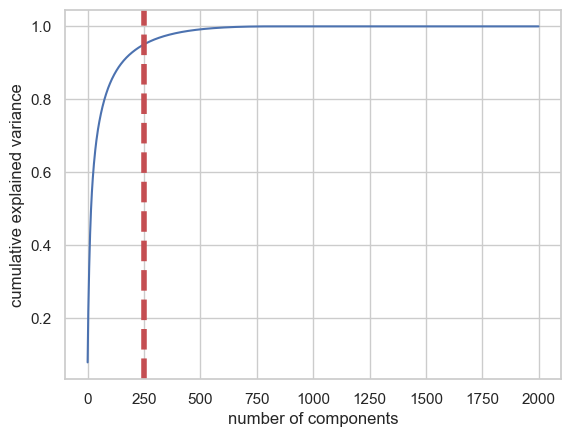

None

,Cumulative Variance Ratio,Explained Variance Ratio
240,0.947080,0.000367
241,0.947446,0.000366
242,0.947809,0.000363
243,0.948169,0.000360
244,0.948526,0.000357
245,0.948882,0.000356
246,0.949235,0.000353
247,0.949585,0.000350
248,0.949934,0.000348
249,0.950276,0.000343


In [28]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=2000)
pca_test.fit(Train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=250, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.iloc[240:251])

Взяв 250 главных компонент мы объясняем 95% дисперсии данных, попробуем посмотреть на результаты предсказаний

In [29]:
pca = PCA(n_components=250)
pca.fit(Train)
Train_pca = pca.transform(Train)
pca.fit(Test)
Test_pca = pca.transform(Test)

In [30]:
n_estimators = [500,700]
min_samples_split = [7,23]
min_samples_leaf = [2,18]
max_features = ['sqrt']
max_depth = [6,13,15]
bootstrap = [False,True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfr, param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(Train_pca, y_train)
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 700}

In [31]:
y_pred = gs.best_estimator_.predict(Test_pca)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.060187806504677366
Mean squared error: 1.2325165256942923
Mean absolute error: 0.9014812592919748
Mean absolute percentage error: 0.12805437954525858


Все стало еще грустнее, но это неудивительно. Применение PCA на отпечатки не несет большого смысла в силу того, что уменьшая размерность путем проецирования на гиперплоскость нужной размерности мы теряем структуру отпечатков, где нужные нам фрагменты описывались единичками. Мы мало того, что теряем объясненную дисперсию, но еще и сильно меняем структуру фичей не в лучшую сторону

# Попробуем градиентный бустинг..

In [32]:
reg = ensemble.GradientBoostingRegressor()
n_estimators = [500]
min_samples_split = [7]
min_samples_leaf = [10]
max_depth = [13]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gs = GridSearchCV(reg, param_grid, cv = 5, verbose = 1, n_jobs=-1)
gs.fit(Train, y_train)
gs.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'max_depth': 13,
 'min_samples_leaf': 10,
 'min_samples_split': 7,
 'n_estimators': 500}

In [33]:
y_pred = gs.best_estimator_.predict(Test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.27147601901556573
Mean squared error: 0.9554226388448942
Mean absolute error: 0.7475003831849716
Mean absolute percentage error: 0.10587177234010348


Градиентый бустинг для данной задачи показывает себя ощутимо хуже по R2, но чуть лучше по MAE

# Перестаем мучить отпечатки и воспользуемся дескрипторами RDKit

# Часть вторая

Из молфайлов получим набор всех дескрипторов

In [91]:
df_desc = df_work[['SMILES','pEC50']]
df_desc = df_desc.reset_index()
df_desc

,index,SMILES,pEC50
0,0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,6.625252
1,1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,6.847712
2,2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,7.866461
3,3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,7.903090
4,4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,7.463442
...,...,...,...
2853,3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,7.540608
2854,3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,5.400000
2855,3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,4.460000
2856,3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,4.950000


In [92]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

In [93]:
Mol_descriptors,desc_names = RDkit_descriptors(df_desc['SMILES'])

In [103]:
df_with_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_descriptors

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.003646,9.003646,0.809080,-4.182984,0.753875,43.434783,315.369,294.201,315.147058,122,...,0,0,0,0,0,0,0,0,0,0
1,8.565450,8.565450,0.768665,-4.049682,0.663186,54.187500,223.272,206.136,223.120843,88,...,0,0,0,0,0,0,0,0,0,0
2,8.829366,8.829366,0.933275,-4.802347,0.552456,54.550000,279.380,254.180,279.183444,112,...,0,0,0,0,0,0,0,0,0,0
3,9.225074,9.225074,0.850433,-4.842125,0.454117,62.391304,315.413,290.213,315.183444,124,...,0,0,0,1,0,0,0,0,0,0
4,8.933912,8.933912,0.773431,-4.074708,0.756255,44.523810,285.343,266.191,285.136493,110,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,14.718630,14.718630,0.075402,-4.407321,0.483930,36.896552,385.467,362.283,385.179027,146,...,0,0,0,0,0,0,0,0,0,0
2854,12.759924,12.759924,0.056282,-4.419477,0.329704,34.090909,326.470,300.262,326.188880,124,...,0,0,0,0,0,1,0,0,0,1
2855,12.657403,12.657403,0.122012,-5.039931,0.122294,24.514286,541.475,516.275,541.154207,202,...,0,0,0,0,0,0,0,0,0,1
2856,12.710647,12.710647,0.081091,-5.039931,0.131090,20.486486,561.465,540.297,561.122907,206,...,0,0,0,0,0,0,0,0,0,1


In [104]:
df_with_descriptors.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,2858.000000,...,2858.000000,2858.000000,2858.000000,2858.000000,2858.0,2858.000000,2858.0,2858.000000,2858.0,2858.000000
mean,11.767827,11.767827,0.428592,-4.586569,0.585049,42.195618,385.916248,359.800654,385.426943,145.351295,...,0.007698,0.003849,0.001749,0.012596,0.0,0.048286,0.0,0.015745,0.0,0.068929
std,2.358917,2.358917,0.290183,0.622083,0.204293,12.077088,113.749922,106.748677,113.564989,42.507185,...,0.087413,0.061930,0.041797,0.111543,0.0,0.217647,0.0,0.124510,0.0,0.256126
min,7.760242,7.760242,0.000053,-7.649036,0.017151,16.800000,138.122000,132.074000,138.031694,52.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
25%,9.207465,9.207465,0.183692,-4.951645,0.447116,35.960685,326.428750,300.237000,326.129824,124.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
50%,12.631522,12.631522,0.403752,-4.639659,0.571786,39.941176,392.499000,362.283000,392.117067,146.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
75%,13.763737,13.763737,0.567470,-4.292080,0.756171,46.448276,436.556000,409.167000,436.247441,164.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
max,17.443288,17.443288,2.037850,-0.786735,0.944216,89.791667,1721.165000,1583.069000,1720.032751,682.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,2.000000,0.0,1.000000,0.0,2.000000


In [105]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_with_descriptors)
scaled_df = pd.DataFrame(scaler.transform(df_with_descriptors), columns = df_with_descriptors.columns)
scaled_df['pEC50'] = df_desc['pEC50']
scaled_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
0,-1.172006,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.625252
1,-1.357800,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.847712
2,-1.245900,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.866461
3,-1.078121,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.903090
4,-1.201573,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.463442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,1.251133,1.251133,-1.217341,0.288192,-0.495057,-0.438847,-0.003950,0.023258,-0.002183,0.015264,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.540608
2854,0.420647,0.420647,-1.283241,0.268648,-1.250112,-0.671199,-0.522696,-0.557844,-0.521714,-0.502386,...,-0.062159,-0.041863,-0.112946,0.0,4.373510,0.0,-0.12648,0.0,3.63584,5.400000
2855,0.377178,0.377178,-1.056688,-0.728908,-2.265546,-1.464296,1.367790,1.466077,1.371501,1.332919,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,3.63584,4.460000
2856,0.399753,0.399753,-1.197733,-0.728908,-2.222487,-1.797861,1.543557,1.691149,1.547367,1.427037,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,3.63584,4.950000


In [106]:
scaled_df.isnull().any(axis=1).sum() # у нас есть 15 строк с пропусками

15

In [107]:
scaled_df.isnull().sum().sum()#суммарно у нас пропущено 180 значениф

180

Найдем колонки с пропусками

In [108]:
a = scaled_df.loc[:, scaled_df.isnull().any()]
a

,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
0,0.332571,-0.806255,0.800134,0.353646,-0.589596,-0.701055,0.552561,-0.180923,0.862530,0.466912,-0.784499,-0.675899
1,0.332571,-0.806255,0.800134,0.353646,-0.589620,-0.594807,0.422881,-0.107624,0.836905,0.606939,-0.787311,-0.685960
2,0.332571,-0.806255,0.800134,0.353646,-0.589616,-0.673437,0.498241,-0.175407,0.883225,0.568055,-0.787069,-0.703072
3,0.332571,-0.806255,0.800134,0.353646,-0.589536,-1.396476,1.091232,-0.737396,1.165565,0.044897,-0.785358,-0.875655
4,0.332571,-0.806255,0.800134,0.353646,-0.589614,-0.698655,0.543566,-0.178330,0.852727,0.467589,-0.785097,-0.675874
...,...,...,...,...,...,...,...,...,...,...,...,...
2853,0.038396,1.629211,-1.658459,0.052668,-0.617625,-0.850932,0.080636,0.503511,0.103564,0.505977,-0.267831,1.450357
2854,0.999213,0.977696,-1.000757,1.035704,0.643872,1.467514,-2.064789,2.312805,-1.154061,0.204359,1.321636,0.618260
2855,2.940066,-0.396404,0.604745,2.809312,0.643872,1.640524,1.504918,2.370215,-1.823030,0.204130,1.315002,-1.501610
2856,2.940066,-0.396404,0.604745,2.809312,0.643872,1.381374,1.505502,2.332185,-1.818354,0.222372,1.315008,-1.501610


Найдем строки среди данных колонок с пропусками

In [109]:
a[a.isnull().any(axis=1)]

,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
1865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Если мы просто выбросим все данные строки, то мы потеряем 15 строк из 2858, что составляет половину процента от всей базы.
Мне кажется, что дозаполнять данный датасет не имеет смысла. Избавимся от строк с пустыми значениями

In [110]:
scaled_df = scaled_df.dropna()
scaled_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
0,-1.172006,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.625252
1,-1.357800,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.847712
2,-1.245900,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.866461
3,-1.078121,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.903090
4,-1.201573,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.463442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,1.251133,1.251133,-1.217341,0.288192,-0.495057,-0.438847,-0.003950,0.023258,-0.002183,0.015264,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.540608
2854,0.420647,0.420647,-1.283241,0.268648,-1.250112,-0.671199,-0.522696,-0.557844,-0.521714,-0.502386,...,-0.062159,-0.041863,-0.112946,0.0,4.373510,0.0,-0.12648,0.0,3.63584,5.400000
2855,0.377178,0.377178,-1.056688,-0.728908,-2.265546,-1.464296,1.367790,1.466077,1.371501,1.332919,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,3.63584,4.460000
2856,0.399753,0.399753,-1.197733,-0.728908,-2.222487,-1.797861,1.543557,1.691149,1.547367,1.427037,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,3.63584,4.950000


С помощью метода IsolationForest мы можем избавиться от того, что данная модель посчитает выбросами, что может быть полезно для нас

In [111]:
from sklearn.ensemble import IsolationForest
data_imputed=scaled_df
iforest = IsolationForest(n_estimators = 500, random_state=0,
    max_samples = "auto", 
    contamination= 0.05 #зададим сами процент потенциальных аномалий в БД
                          #Иначе алгоритм попытается определить это самостоятельно, иногда удаляя слишком много данных
    )
iforest_fit = iforest.fit(data_imputed)
predictions = iforest_fit.predict(data_imputed)

data_imputed['is_anomaly_prediction'] = predictions
data_imputed = data_imputed[data_imputed.is_anomaly_prediction != -1]
data_imputed = data_imputed.drop(columns = ['is_anomaly_prediction'])
data_imputed.describe()

C:\Users\Max\AppData\Local\Temp\ipykernel_1468\1124542492.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_imputed['is_anomaly_prediction'] = predictions


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.0,2700.000000,2700.0,2700.000000,2700.0,2700.000000,2700.000000
mean,-0.030917,-0.030917,-0.002156,0.064616,0.102978,0.002412,-0.116813,-0.115441,-0.116983,-0.118471,...,-0.002344,0.002450,-0.000033,0.0,-0.070413,0.0,0.001451,0.0,-0.050778,7.334282
std,1.003725,1.003725,0.970950,0.960708,0.912191,0.984111,0.774877,0.783783,0.774126,0.742579,...,0.981217,1.028981,1.000043,0.0,0.820613,0.0,1.005814,0.0,0.897454,1.128436
min,-1.699206,-1.699206,-1.477047,-4.095284,-2.142916,-2.083531,-2.046384,-2.039798,-2.046305,-2.008278,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,4.251812
25%,-1.133993,-1.133993,-0.829174,-0.483338,-0.559532,-0.507180,-0.549373,-0.576789,-0.548138,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,6.568636
50%,0.353484,0.353484,-0.078692,-0.013587,0.034295,-0.186704,-0.012664,-0.016824,-0.011376,0.015264,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,7.310781
75%,0.822700,0.822700,0.472460,0.497356,0.857742,0.344431,0.390319,0.388010,0.384898,0.344677,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,8.142668
max,2.301640,2.301640,5.546643,6.109313,1.758402,2.851300,2.711533,2.860174,2.691306,2.085864,...,16.087827,23.887235,8.853750,0.0,4.373510,0.0,7.906397,0.0,3.635840,11.000000


У нас осталось 2700 сэмплов из 2858 исходных.

# Посмотрим на кореляцию наших признаков

In [112]:
sp_corr_mat = data_imputed.corr(method = 'spearman')
sp_corr_mat

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
MaxAbsEStateIndex,1.000000,1.000000,0.006296,-0.394845,-0.096344,-0.081791,0.445746,0.444698,0.446086,0.465947,...,0.036111,0.025582,0.052448,NaN,-0.099855,NaN,0.020295,NaN,0.190359,-0.143295
MaxEStateIndex,1.000000,1.000000,0.006296,-0.394845,-0.096344,-0.081791,0.445746,0.444698,0.446086,0.465947,...,0.036111,0.025582,0.052448,NaN,-0.099855,NaN,0.020295,NaN,0.190359,-0.143295
MinAbsEStateIndex,0.006296,0.006296,1.000000,-0.214451,0.121667,0.183061,-0.059964,-0.081274,-0.058695,-0.019028,...,0.078964,-0.001531,0.123519,NaN,-0.200608,NaN,-0.149780,NaN,0.225699,-0.019098
MinEStateIndex,-0.394845,-0.394845,-0.214451,1.000000,0.257762,-0.252659,-0.605138,-0.572822,-0.607310,-0.675930,...,-0.100579,-0.072325,-0.126016,NaN,-0.088434,NaN,0.023882,NaN,-0.236091,-0.142163
qed,-0.096344,-0.096344,0.121667,0.257762,1.000000,0.541951,-0.683773,-0.693091,-0.684284,-0.678417,...,0.035985,0.005543,-0.114348,NaN,-0.058318,NaN,-0.042190,NaN,0.233310,-0.027480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_thiocyan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fr_thiophene,0.020295,0.020295,-0.149780,0.023882,-0.042190,-0.060366,0.045792,0.051471,0.044957,0.020952,...,-0.007756,-0.005480,-0.014366,NaN,-0.023487,NaN,1.000000,NaN,-0.018088,0.042513
fr_unbrch_alkane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fr_urea,0.190359,0.190359,0.225699,-0.236091,0.233310,0.265640,-0.045456,-0.062387,-0.045175,-0.031004,...,-0.014840,-0.010484,-0.027486,NaN,0.000204,NaN,-0.018088,NaN,1.000000,-0.006532


<Axes: title={'center': 'Spearman Correlation Matrix'}>

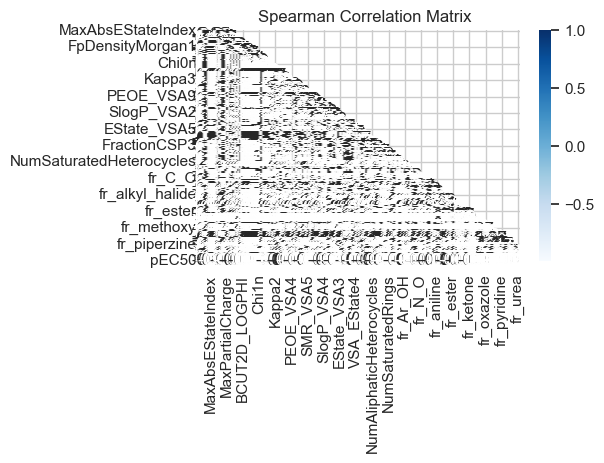

In [113]:
fig = plt.figure(figsize=(5, 3))
plt.title("Spearman Correlation Matrix")
mask = np.triu(np.ones_like(sp_corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(sp_corr_mat,
           mask = mask,
           cmap="Blues", annot=True, center=0, fmt='.2f')


Выше мы можем на глаз видеть много различных признаков, которые сильно коррелируют. Но при таком количестве признаков на глаз найти все пары и убрать ненужные фичи практически невозможно

Поэтому воспользуемся функцией:
с ее помощью мы можем получить список списков пар всех фичей, корреляция которых превышает 0.6

In [114]:
def print_highly_correlated(df, features, threshold=0.6):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df[features].corr(method = 'spearman') # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    g = []
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            g.append([corr_df.columns[j],corr_df.index[i]])
            print ("%s and %s = %.3f" % (corr_df.index[i], corr_df.columns[j], v))
    return(g)

In [115]:
high_cor_pairs = print_highly_correlated(df=data_imputed, features=data_imputed.columns)


MaxAbsEStateIndex and MaxEStateIndex = 1.000
NumAromaticCarbocycles and fr_benzene = 1.000
fr_Ar_NH and fr_Nhpyrrole = 1.000
fr_COO and fr_COO2 = 1.000
fr_ketone and fr_ketone_Topliss = 1.000
fr_nitro and fr_nitro_arom = 1.000
MolWt and ExactMolWt = 1.000
MaxPartialCharge and MinAbsPartialCharge = 0.999
Chi0n and Chi1n = 0.999
MolWt and HeavyAtomMolWt = 0.998
HeavyAtomMolWt and ExactMolWt = 0.997
fr_phenol and fr_phenol_noOrthoHbond = 0.997
MinPartialCharge and MaxAbsPartialCharge = -0.996
Chi0 and Chi1n = 0.995
Chi0 and Chi0n = 0.995
MolWt and Chi0v = 0.995
ExactMolWt and Chi0v = 0.995
fr_C_O and fr_C_O_noCOO = 0.993
HeavyAtomMolWt and Chi0v = 0.992
Chi0 and Chi1 = 0.991
Chi0v and Chi1v = 0.991
NumValenceElectrons and HeavyAtomCount = 0.990
NumValenceElectrons and LabuteASA = 0.990
LabuteASA and MolMR = 0.988
Chi0v and MolMR = 0.985
Chi1 and Chi1n = 0.984
fr_Ar_OH and fr_phenol = 0.982
Chi1 and EState_VSA1 = 0.982
NHOHCount and NumHDonors = 0.982
HeavyAtomMolWt and Chi1v = 0.980
NumVa

In [116]:
len(high_cor_pairs)

733

Итого у нас есть 208 пар высокоскоррелированных признаков, сейчас нам нужно начать удалять признаки, но так чтобы не удалить лишние. Так как есть пересечения между различными признаками

In [117]:
def print_highly_correlated2(df, features, threshold=0.6):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df[features].corr(method = 'spearman') # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    g = []
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            g.append([corr_df.columns[j],corr_df.index[i]])
    return(g)

In [118]:
df_drop = data_imputed.drop(high_cor_pairs[0][0],axis=1)
df_drop

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
0,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.625252
1,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.847712
2,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.866461
3,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,0.0,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.903090
4,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.463442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,1.316609,-1.074987,0.144999,-0.571780,-0.465009,0.260061,0.285696,0.262122,0.297618,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.206908
2850,1.258824,-1.255165,0.317358,-0.747851,-0.543462,0.298916,0.355433,0.296914,0.156441,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.095826
2851,1.257022,-1.247979,0.310522,-0.747851,-0.543462,0.298916,0.355433,0.296914,0.156441,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.355561
2852,1.307384,-1.090226,0.159095,-0.596362,-0.386111,0.119386,0.135794,0.121253,0.156441,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.562249


In [119]:
while high_cor_pairs != []:
    high_cor_pairs = print_highly_correlated2(df=df_drop, features=df_drop.columns)
    if high_cor_pairs == []:
        break
    df_drop = df_drop.drop(high_cor_pairs[0][0],axis=1)


There are no highly correlated features with correlation above 0.6


Теперь в нашем датасете нет ни одной пары признаков корреляция спирмана для которых >=0.6

In [120]:
df_drop

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
0,-1.172006,1.311432,0.648877,0.826533,0.102623,0.0,0.332571,-0.806255,0.706162,-0.589596,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,6.625252
1,-1.357800,1.172134,0.863199,0.382541,0.993119,0.0,0.332571,-0.806255,2.389627,-0.589620,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,6.847712
2,-1.245900,1.739495,-0.346924,-0.159567,1.023139,0.0,0.332571,-0.806255,1.225505,-0.589616,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.866461
3,-1.078121,1.453965,-0.410879,-0.641016,1.672524,0.0,0.332571,-0.806255,0.882210,-0.589536,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.903090
4,-1.201573,1.188559,0.822963,0.838187,0.192811,0.0,0.332571,-0.806255,0.328914,-0.589614,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.463442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,1.316609,-1.074987,0.144999,-0.571780,-0.465009,0.0,0.038396,-0.702841,-0.883956,-0.592373,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.206908
2850,1.258824,-1.255165,0.317358,-0.747851,-0.543462,0.0,0.038406,1.629211,-0.731569,0.909147,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.095826
2851,1.257022,-1.247979,0.310522,-0.747851,-0.543462,0.0,0.038396,1.629211,-0.866540,0.909147,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.355561
2852,1.307384,-1.090226,0.159095,-0.596362,-0.386111,0.0,0.038396,1.629211,-1.001511,-0.617624,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.562249


<Axes: title={'center': 'Spearman Correlation Matrix'}>

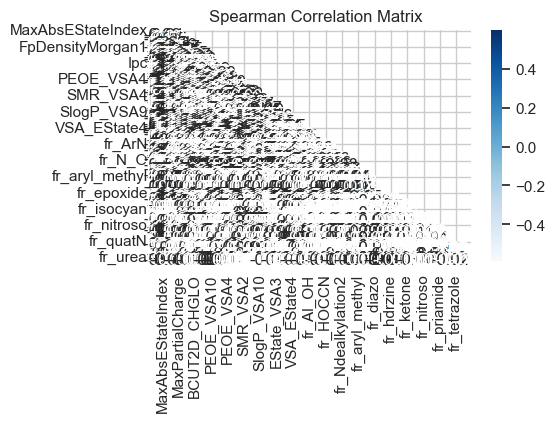

In [121]:
sp_corr_mat = df_drop.corr(method = 'spearman')
fig = plt.figure(figsize=(5, 3))
plt.title("Spearman Correlation Matrix")
mask = np.triu(np.ones_like(sp_corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(sp_corr_mat,
           mask = mask,
           cmap="Blues", annot=True, center=0, fmt='.2f')


Как видим теперь максимум на графике соответсвует 0.6, чего мы и хотели добиться :)
цифра 0.6 появилась постфактум, потому что изначально я брал значение в 0.85, но разница между моделями была еще меньше..

Таким образом мы понизили размерность с 211 до 114

# Battle двух датасетов:

Дата сет со всеми посчитанными дескрипторами RDKit (**df1**) vs Очищенный от лишних фичей (по критерию корреляции Спирмана) (**df2**) 

In [122]:
df1 = data_imputed
df1

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
0,-1.172006,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.625252
1,-1.357800,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,6.847712
2,-1.245900,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.866461
3,-1.078121,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.903090
4,-1.201573,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.463442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,1.316609,1.316609,-1.074987,0.144999,-0.571780,-0.465009,0.260061,0.285696,0.262122,0.297618,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.206908
2850,1.258824,1.258824,-1.255165,0.317358,-0.747851,-0.543462,0.298916,0.355433,0.296914,0.156441,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.095826
2851,1.257022,1.257022,-1.247979,0.310522,-0.747851,-0.543462,0.298916,0.355433,0.296914,0.156441,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.355561
2852,1.307384,1.307384,-1.090226,0.159095,-0.596362,-0.386111,0.119386,0.135794,0.121253,0.156441,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.12648,0.0,-0.26917,7.562249


In [123]:
df2 = data_imputed[df_drop.columns]
df2

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pEC50
0,-1.172006,1.311432,0.648877,0.826533,0.102623,0.0,0.332571,-0.806255,0.706162,-0.589596,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,6.625252
1,-1.357800,1.172134,0.863199,0.382541,0.993119,0.0,0.332571,-0.806255,2.389627,-0.589620,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,6.847712
2,-1.245900,1.739495,-0.346924,-0.159567,1.023139,0.0,0.332571,-0.806255,1.225505,-0.589616,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.866461
3,-1.078121,1.453965,-0.410879,-0.641016,1.672524,0.0,0.332571,-0.806255,0.882210,-0.589536,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.903090
4,-1.201573,1.188559,0.822963,0.838187,0.192811,0.0,0.332571,-0.806255,0.328914,-0.589614,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.463442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,1.316609,-1.074987,0.144999,-0.571780,-0.465009,0.0,0.038396,-0.702841,-0.883956,-0.592373,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.206908
2850,1.258824,-1.255165,0.317358,-0.747851,-0.543462,0.0,0.038406,1.629211,-0.731569,0.909147,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.095826
2851,1.257022,-1.247979,0.310522,-0.747851,-0.543462,0.0,0.038396,1.629211,-0.866540,0.909147,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.355561
2852,1.307384,-1.090226,0.159095,-0.596362,-0.386111,0.0,0.038396,1.629211,-1.001511,-0.617624,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917,7.562249


In [124]:
X = df1.drop(['pEC50'],axis=1)
y = df1['pEC50']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

In [125]:
X_traindf2 = X_train[df_drop.drop(['pEC50'],axis=1).columns]
X_testdf2 =  X_test[df_drop.drop(['pEC50'],axis=1).columns]

У нас готовы одинаковые сэмплы, X_train (df1) и X_traindf2 (df2), теперь мы можем объективно сравнивать эффективность моделей основанных на наших датасетах

In [126]:
X_traindf2

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_prisulfonamd,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1983,0.855556,-0.146587,-0.090812,1.335534,1.344347,0.0,0.741065,1.725133,0.714545,0.909147,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,3.63584
338,1.186396,0.215752,-1.423742,-1.010723,-2.023772,0.0,1.966356,-0.251330,-1.266798,-0.359782,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
2328,0.908034,-1.283291,0.210853,0.617332,-0.507180,0.0,0.022569,-0.700893,0.039692,-0.590937,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
1592,-1.148230,-0.858171,0.228079,1.173409,2.851300,0.0,-1.039967,2.018154,2.389627,-0.694178,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
590,-0.953732,-0.717595,-1.312272,-0.377627,0.580561,0.0,-1.167867,0.977698,-0.691872,0.643872,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,0.882088,0.121179,-0.393962,-0.520915,-0.539811,0.0,-0.222114,1.079670,-1.275806,0.909349,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
929,0.367005,-0.041046,-0.395941,0.276935,0.143910,0.0,-0.582184,-0.657305,-0.596599,0.909349,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
76,-1.085980,0.598120,1.290790,0.603476,-0.012059,0.0,0.332438,-0.806261,0.010769,0.905778,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917
2332,0.970141,1.627995,0.243922,1.029789,-0.283759,0.0,-0.191617,-0.702723,-0.004804,-0.591340,...,0.0,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.12648,0.0,-0.26917


In [128]:
from sklearn.model_selection import RandomizedSearchCV
rfr = RandomForestRegressor()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfr, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_traindf2, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

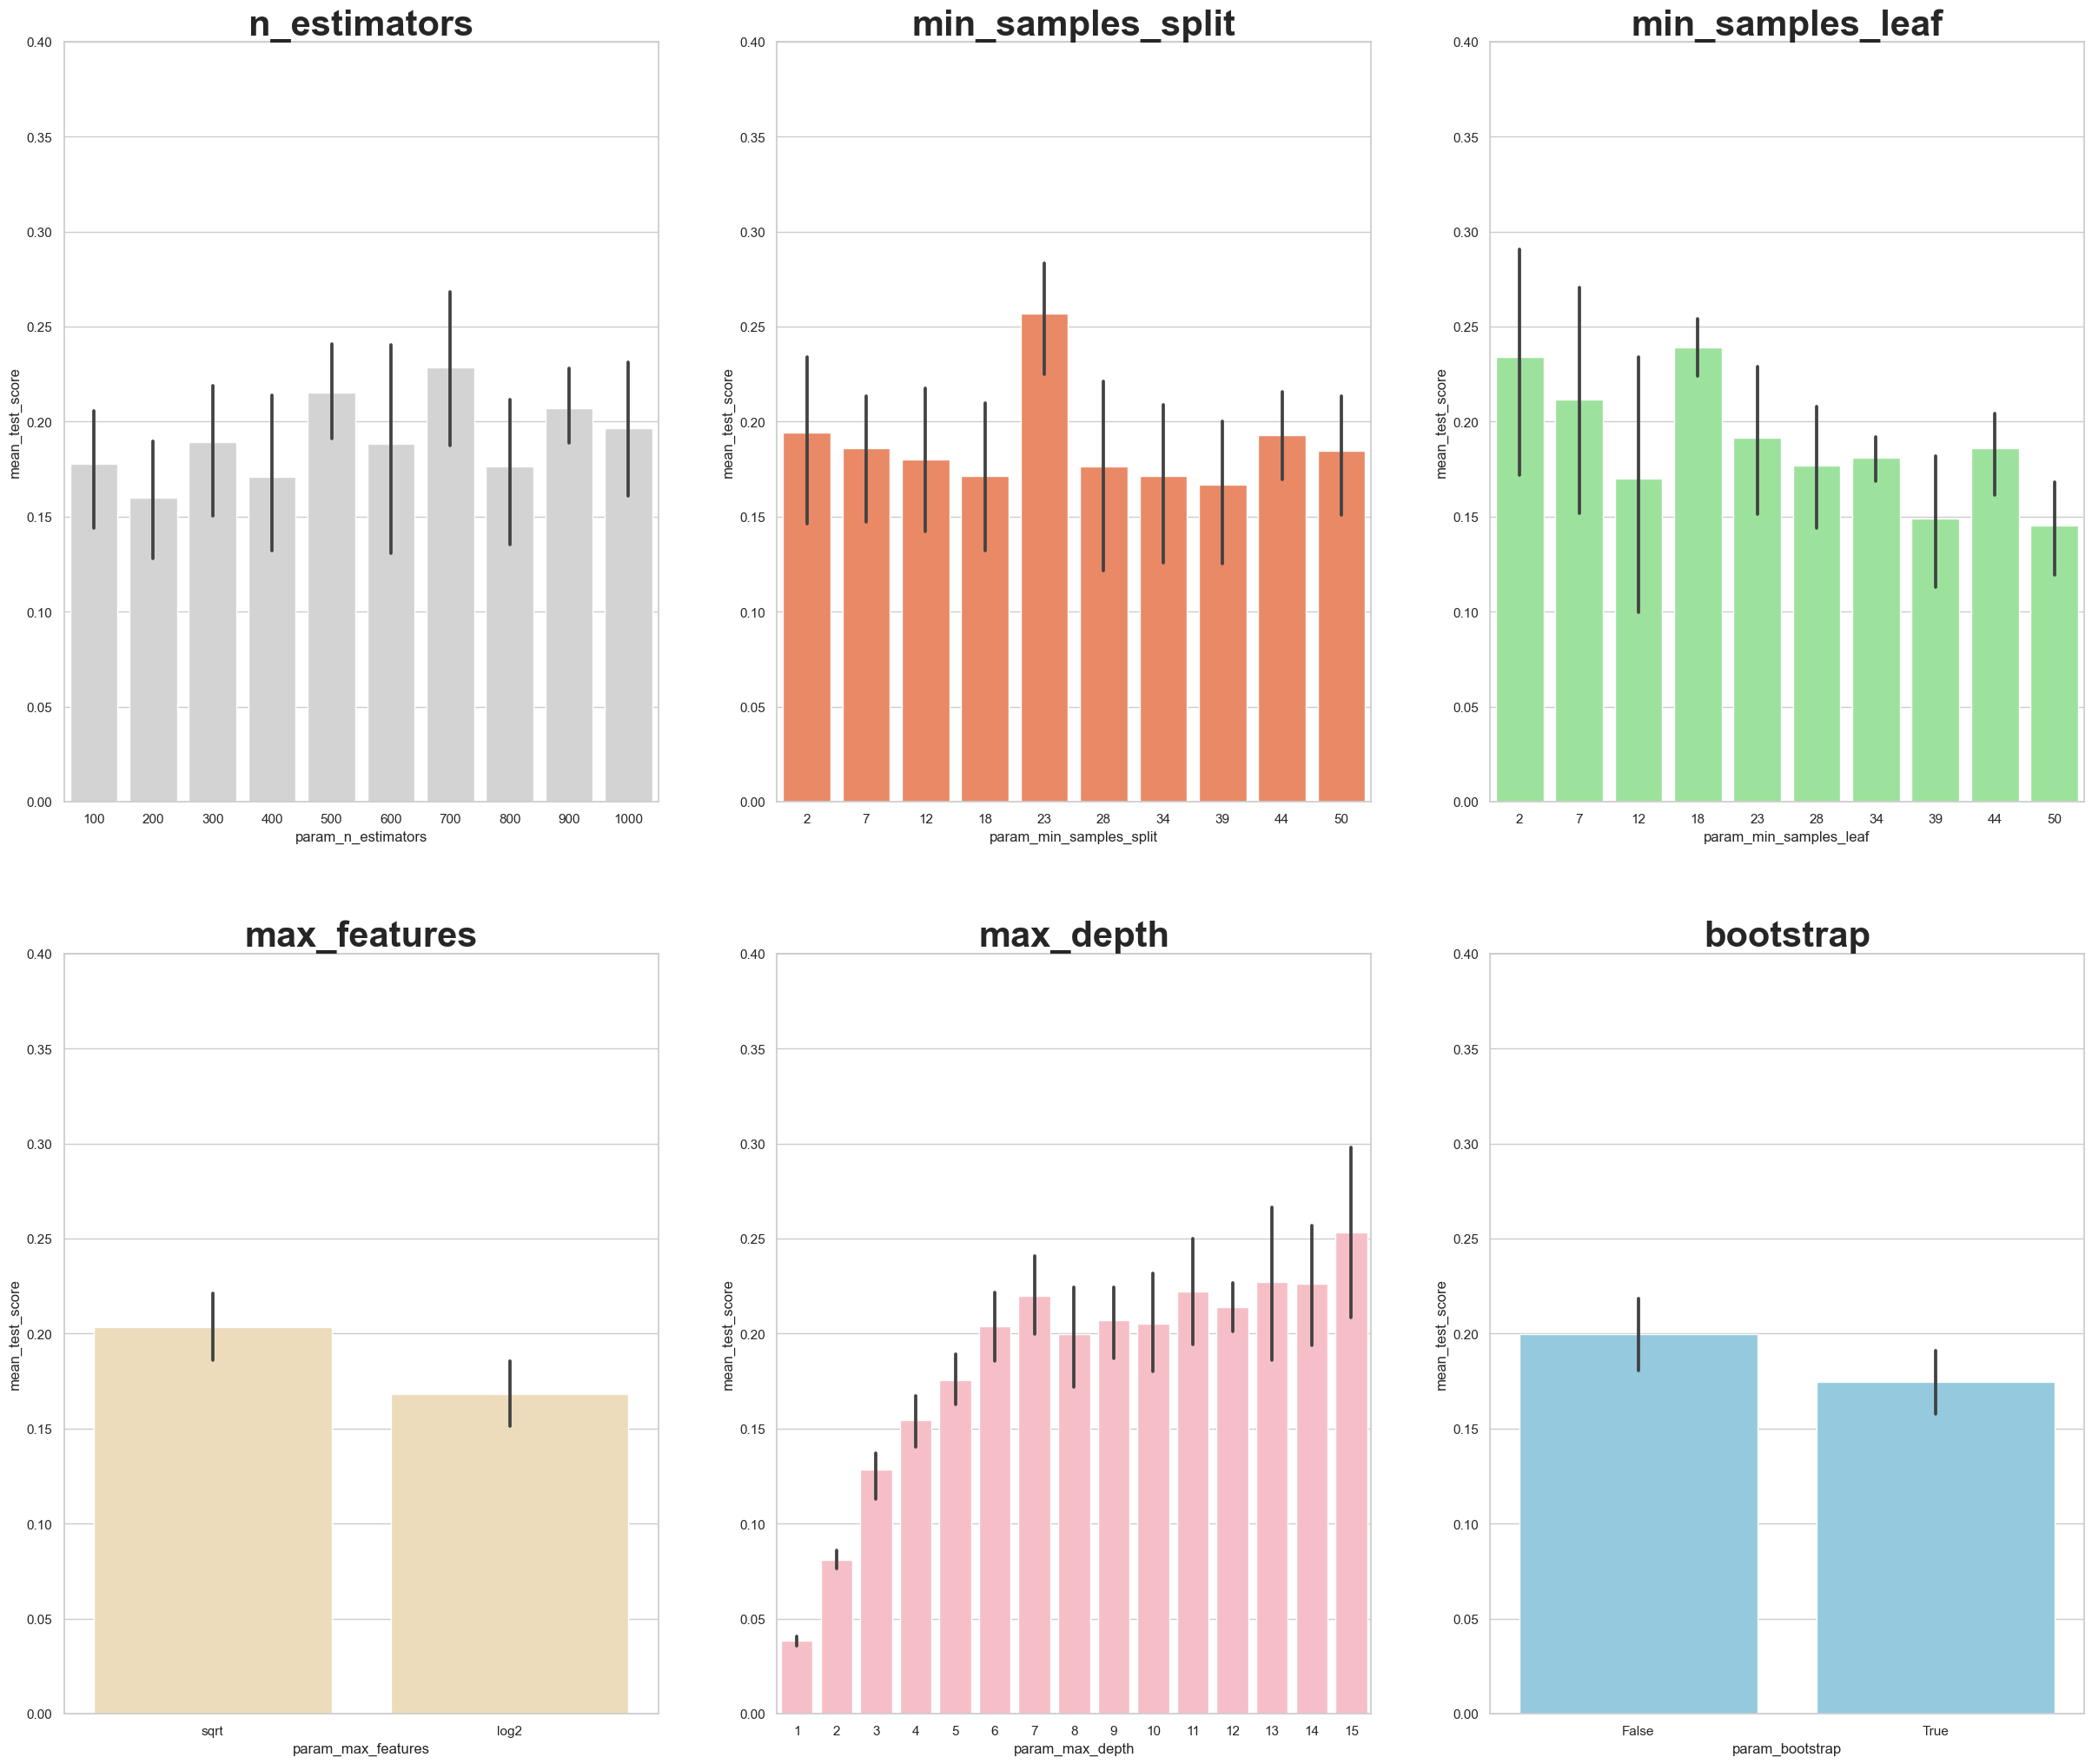

In [129]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot( data=rs_df,x='param_n_estimators', y='mean_test_score', ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([0,0.4])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([0,0.4])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([0,0.4])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([0,0.4])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([0,0.4])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([0,0.4])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()


In [130]:
n_estimators = [500,700]
min_samples_split = [23,44]
min_samples_leaf = [2,18]
max_features = ['sqrt']
max_depth = [7,13,15]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfr, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_traindf2, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


{'bootstrap': True,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 700}

In [131]:
y_pred = gs.best_estimator_.predict(X_testdf2)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.36710239313100945
Mean squared error: 0.7900994711294631
Mean absolute error: 0.7059629466610295
Mean absolute percentage error: 0.10031079359686343


Результаты оказались не настолько впечатляющими, как я ожидал

In [132]:
rfc_3.fit(X_train, y_train)
y_pred = rfc_3.predict(X_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.37442611209050225
Mean squared error: 0.7809566549554181
Mean absolute error: 0.6947616846466108
Mean absolute percentage error: 0.09872728761432736


Разница оказалась минимальна для RFR.......
Да, в случае df2, где размерность ниже результат немного хуже, но это совсем минимальная разница, нооооо мы уменьшили размерность ощутимо! Не потеряв качества, это уже победа

Посмотрим градиентный бустинг.. (я не перебираю большое количество гиперпараметров в силу того, что мой комп итак взрывается от него..)

In [133]:
reg = ensemble.GradientBoostingRegressor()
n_estimators = [500]
min_samples_split = [13]
min_samples_leaf = [10]
max_depth = [13]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gs = GridSearchCV(reg, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_traindf2, y_train)
gbr = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'max_depth': 13,
 'min_samples_leaf': 10,
 'min_samples_split': 13,
 'n_estimators': 500}

In [134]:
y_pred = gs.best_estimator_.predict(X_testdf2)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.21537929036797976
Mean squared error: 0.9795082190061243
Mean absolute error: 0.7338091826656238
Mean absolute percentage error: 0.10335414512430216


In [135]:
gbr.fit(X_train, y_train)
y_pred = rfc_3.predict(X_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.37442611209050225
Mean squared error: 0.7809566549554181
Mean absolute error: 0.6947616846466108
Mean absolute percentage error: 0.09872728761432736


Градиентный бустинг дал другую ситуацию... но с гораздо большей разницей между сетами


# Попробуем понизить размерность с помощью PCA

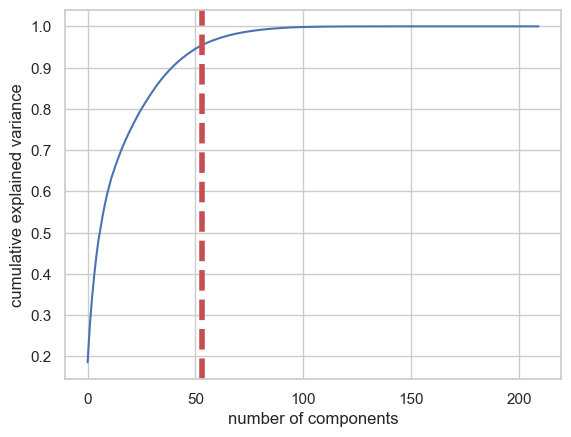

None

,Cumulative Variance Ratio,Explained Variance Ratio
50,0.945705,0.003355
51,0.948859,0.003153
52,0.951800,0.002941
53,0.954552,0.002752
54,0.957107,0.002555
55,0.959500,0.002393
56,0.961745,0.002245
57,0.963870,0.002125
58,0.965870,0.002000
59,0.967755,0.001886


In [136]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=210)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=53, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.iloc[50:60])

Взяв 53 главных компонент мы объясняем 95% дисперсии данных, попробуем посмотреть на результаты предсказаний

In [137]:
pca = PCA(n_components=53)
pca.fit(X_train)
Train_pca = pca.transform(X_train)
pca.fit(X_test)
Test_pca = pca.transform(X_test)

In [138]:
rfc_3.fit(Train_pca,y_train)
y_pred = rfc_3.predict(Test_pca)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.02199217071670001
Mean squared error: 1.2209296737586857
Mean absolute error: 0.9114822618885962
Mean absolute percentage error: 0.12840927762809629


Как видно, использование метода главных компонент на датасете со всеми дескрипторами дает ощутимо худший результат, что логично, ведь у нас крайне много высокоскоррелированных признаков, которые никуда не делись, а лишь проецировались на гиперплоскость..

Посмотрим результат на исходных данных из датасета, да мы разобьем данные най трейн и тест другим образом, результат нельзя будет сравнивать напрямую, но оценить порядок ошибки мы сможем  
Здесь я энкодю категориальную переменную, чтобы она правильно воспринималась нашими моделями

In [139]:
old = filtered_df.drop(['Assay Type','EC50 (nM)','SMILES'],axis=1)
df_encoded = pd.get_dummies(old, columns=['Target Name'], dtype = int)
y = df_encoded['pEC50']
X = df_encoded.drop('pEC50',axis=1)
df_encoded

,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds,Target Name_Dopamine D1 receptor,Target Name_Dopamine D2 receptor,Target Name_Dopamine D3 receptor,Target Name_Dopamine D4 receptor,Target Name_Dopamine D5 receptor
0,6.625252,315.369,2.29020,3.0,5.0,84.94,3.0,4.0,1,0,0,0,0
1,6.847712,223.272,1.44890,3.0,4.0,75.71,2.0,2.0,1,0,0,0,0
2,7.866461,279.380,3.00930,3.0,4.0,75.71,2.0,6.0,1,0,0,0,0
3,7.903090,315.413,2.88330,3.0,4.0,61.72,3.0,4.0,1,0,0,0,0
4,7.463442,285.343,2.28160,3.0,4.0,75.71,3.0,3.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3120,7.540608,385.467,4.28530,0.0,5.0,56.89,5.0,2.0,0,0,0,0,1
3121,5.400000,326.470,1.77042,4.0,4.0,118.42,1.0,8.0,0,0,0,0,1
3122,4.460000,541.475,2.12360,6.0,7.0,205.91,1.0,8.0,0,0,0,0,1
3123,4.950000,561.465,2.13360,6.0,7.0,205.91,2.0,6.0,0,0,0,0,1


In [140]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

In [141]:
n_estimators = [500,700]
min_samples_split = [23,44]
min_samples_leaf = [2,18]
max_features = ['sqrt']
max_depth = [7,13,15]
bootstrap = [False,True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfr, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 700}

In [142]:
y_pred = gs.best_estimator_.predict(X_test)
print('R2 score:', r2_score(y_test,y_pred))
print('Mean squared error:',mean_squared_error(y_test,y_pred))
print('Mean absolute error:',mean_absolute_error(y_test,y_pred))
print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_pred))

R2 score: 0.3199306108855291
Mean squared error: 0.8918768733836172
Mean absolute error: 0.7261527544544696
Mean absolute percentage error: 0.10330019655409599


# Итого мы имеем следующие результаты для задачи регрессии:

В случае использования отпечатков моргана радиуса 2, битности 2048 и использования **RandomForestRegressor** в качестве модели, при оптимизации гиперпараметров мы получаем: (в схожих исследованиях в основном ориентируется на значение MAE, как ключевое)   
**R2 score: 0.3154795876046378  
Mean absolute error: 0.7552310235089378**

Если мы используем все то же самое, но дополнительно пользуемся **PCA** для понижения размерности мы получаем результаты ощутимо хуже:  
**R2 score: 0.060187806504677366  
Mean absolute error: 0.9014812592919748**

**GradientBoostingRegressor** для данной задачи показывает себя хуже по R2, но чуть лучше по MAE  
**R2 score: 0.27147601901556573  
Mean absolute error: 0.7475003831849716**


И казалось, что отсюда хочется сделать вывод, что задачу QSAR для данного датасета не получится решить эффективно, и следущий логичный шаг это посмотреть на результаты использования дескрипторов RDKit.  
Таким образом мы получили два датасета, один в котором содержатся все дискрипторы посчитанные RDKit, без какой либо доп обработки, кроме удаления NaN. Над вторым сетом уже проведена большая работа, в нем был проведен анализ корреляций признаков Спирмана и исходя их этого были удалены признаки таким образом, чтобы не осталось пар, для который корреляция спирмана превосходила бы **0.6**.  

Результаты **RFR** для датасета с дескрипторами без обработки  
**R2 score: 0.37442611209050225  
Mean absolute error: 0.6947616846466108**  

Результаты **GBR** для датасета с дескрипторами без обработки  
**R2 score: 0.37442611209050225  
Mean absolute error: 0.6947616846466108**  

Результаты **RFR** для датасета с обработкой высокоскоррелированных признаков:  
**R2 score: 0.36710239313100945  
Mean absolute error: 0.7059629466610295**  

Результаты **GBR** для датасета с обработкой высокоскоррелированных признаков:   
**R2 score: 0.21537929036797976  
Mean absolute error: 0.7338091826656238**  

Результаты **RFR** для датасета со всеми дескрипторами, но с использованием PCA:     
**R2 score: 0.02199217071670001  
Mean absolute error: 0.9114822618885962**  

Также можно посмотреть на результаты для модели, обученной на заранее отобранных авторами датасета признаков:  
**RFR**:  
**R2 score: 0.3199306108855291  
Mean absolute error: 0.7261527544544696**  

Таким образом с помощью дескрипторов RDKita мы смогли добиться ощутимо лучших результатов как по R2 так и по MAE
Оптимальным методом для решения данной проблемы, это использовать дескрипторы RDKita с последующим удалением ненужных высоскоррелированных фичей и в качестве модели использовать RandomForestRegressor с последующей оптимизацией гиперпараметров.

В интернете я нашел проект чувака, который на этом датасете решал схожую задачу, и невероятно, но у меня результат по MAE лучше на 0.1:)  

итого часть про регрессию все...

# Часть 3: Задача Классификации с помощью отпечатков

С помощью отпечатков моргана в качестве фичей создадим модель классификации одного из 5 типов допаминовых рецепторов (Target Name)

In [143]:
class_df = filtered_df[['SMILES','Target Name']]
class_df

,SMILES,Target Name
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,Dopamine D1 receptor
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,Dopamine D1 receptor
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,Dopamine D1 receptor
...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,Dopamine D5 receptor
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,Dopamine D5 receptor
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,Dopamine D5 receptor
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,Dopamine D5 receptor


На всякий случай канонизируем смайлз

In [144]:
class_df['SMILES'] = class_df['SMILES'].apply(lambda x: Chem.CanonSmiles(x))

C:\Users\Max\AppData\Local\Temp\ipykernel_1468\252028635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_df['SMILES'] = class_df['SMILES'].apply(lambda x: Chem.CanonSmiles(x))


Добавим столбец с мол-файлами

In [145]:
PandasTools.AddMoleculeColumnToFrame(class_df, smilesCol='SMILES', molCol='Molecule')

C:\Users\Max\anaconda3\Lib\site-packages\rdkit\Chem\PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Target Name,Molecule
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,Dopamine D1 receptor,
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor,
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor,
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,Dopamine D1 receptor,
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,Dopamine D1 receptor,
...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,Dopamine D5 receptor,
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,Dopamine D5 receptor,
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,Dopamine D5 receptor,
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,Dopamine D5 receptor,

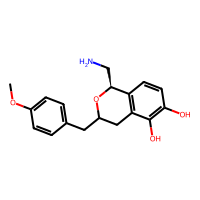
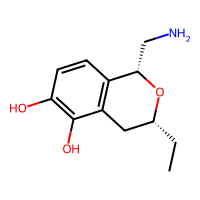
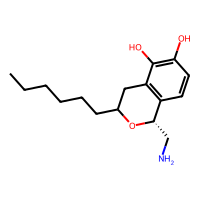
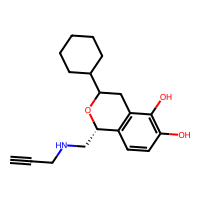
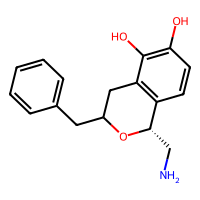
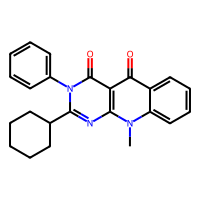
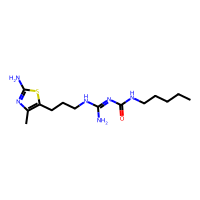
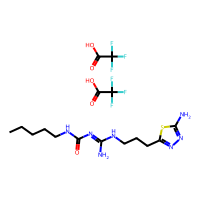
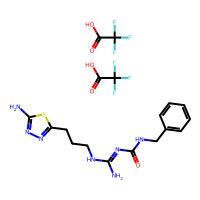
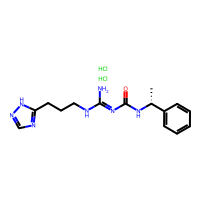

In [146]:
class_df

Добавим отпечатки пальцев r = 2, битность 2048

In [147]:
def fpgen(x,n,size):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=n,fpSize=size,includeChirality=True)
    e = mfpgen.GetFingerprint(x)#получаем FP
    return (e) 

C:\Users\Max\AppData\Local\Temp\ipykernel_1468\3543202830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_df[f'fp{i},{b}'] = class_df['Molecule'].apply(lambda x: fpgen(x,i,b))


,SMILES,Target Name,Molecule,"fp2,2048"
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,Dopamine D1 receptor,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,Dopamine D1 receptor,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,Dopamine D1 receptor,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
3120,Cn1c2ccccc2c(=O)c2c(=O)n(-c3ccccc3)c(C3CCCCC3)...,Dopamine D5 receptor,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3121,CCCCCNC(=O)/N=C(\N)NCCCc1sc(N)nc1C,Dopamine D5 receptor,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3122,CCCCCNC(=O)/N=C(\N)NCCCc1nnc(N)s1.O=C(O)C(F)(F...,Dopamine D5 receptor,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3123,N/C(=N\C(=O)NCc1ccccc1)NCCCc1nnc(N)s1.O=C(O)C(...,Dopamine D5 receptor,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

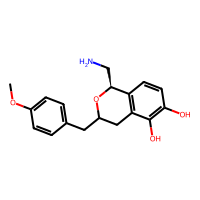
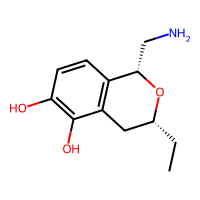
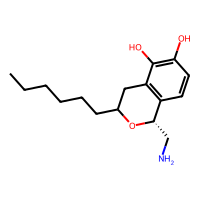
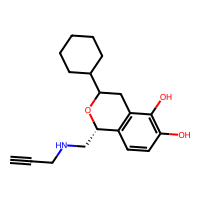
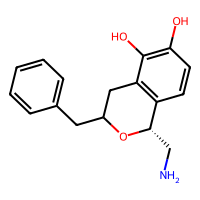
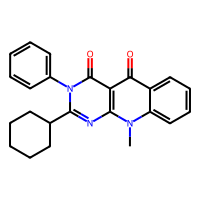
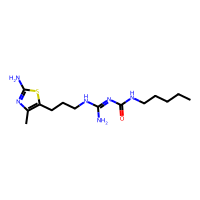
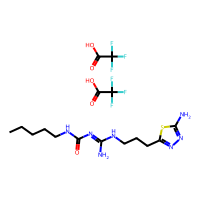
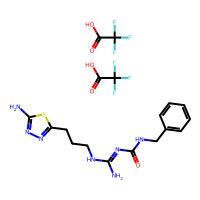
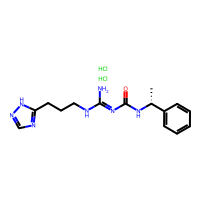

In [148]:
r = [2]
bit = [2048]
for i in r:
    for b in bit:
        class_df[f'fp{i},{b}'] = class_df['Molecule'].apply(lambda x: fpgen(x,i,b))
class_df

In [149]:
class_df['Target Name'].value_counts()

Target Name
Dopamine D2 receptor    1400
Dopamine D3 receptor     657
Dopamine D1 receptor     432
Dopamine D4 receptor     336
Dopamine D5 receptor      33
Name: count, dtype: int64

Из распределения классов выше видно, что D5 слишком мало. Проще его убрать и сосредоточиться на предсказании оставшихся

In [150]:
class_df = class_df[class_df['Target Name'] !='Dopamine D5 receptor']

In [151]:
class_df

,SMILES,Target Name,Molecule,"fp2,2048"
0,COc1ccc(CC2Cc3c(ccc(O)c3O)[C@H](CN)O2)cc1,Dopamine D1 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAED1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC[C@@H]1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAED1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCCCCCC1Cc2c(ccc(O)c2O)[C@H](CN)O1,Dopamine D1 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAED1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C#CCNC[C@@H]1OC(C2CCCCC2)Cc2c1ccc(O)c2O,Dopamine D1 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAED1...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NC[C@@H]1OC(Cc2ccccc2)Cc2c1ccc(O)c2O,Dopamine D1 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAED1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
3086,CCS[C@H]1CC[C@@H](N(C)CC(=O)Nc2ccc(C)c(C)c2)C1,Dopamine D4 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAD96...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3087,CCOC(=O)c1sc2[nH]cn/c(=N\[C@H]3CCN(CC)C3)c2c1C,Dopamine D4 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAD96...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3088,CCOC(=O)c1nn(-c2ccccc2)cc1CN(C)[C@@H]1CCSC1,Dopamine D4 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAD96...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3089,CN(C)[C@@H](CNC(=O)NC[C@H]1Cc2ccccc21)CC1CCCCC1,Dopamine D4 receptor,<rdkit.Chem.rdchem.Mol object at 0x000001FAD96...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Разбиваем сет на трейн и тест с самого начала

In [152]:
X = class_df.drop(['SMILES','Target Name','Molecule'],axis=1)
y = class_df['Target Name']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13, stratify=y)

In [153]:
d = np.ones(shape=(2048,))
for fp in X_test['fp2,2048']:
    d = np.vstack((d,np.array(fp)))
d = np.delete(d,0,0)        
Test = d
d = np.ones(shape=(2048,))
for fp in X_train['fp2,2048']:
    d = np.vstack((d,np.array(fp)))
d = np.delete(d,0,0)     
Train = d

У нас готов датасет с отпечатками радиуса =2 и битностью 2048 в качестве фичей

# Проведем оптимизацию гиперпараметров для RFC

Сначала воспользуемся RandomizedSearchCV а потом уже GridSearchem

In [154]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(Train, y_train)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 600,
 'min_samples_split': 23,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

После чего строю графики для каждого параметра, где можно будет визуально увидеть лучшие значения

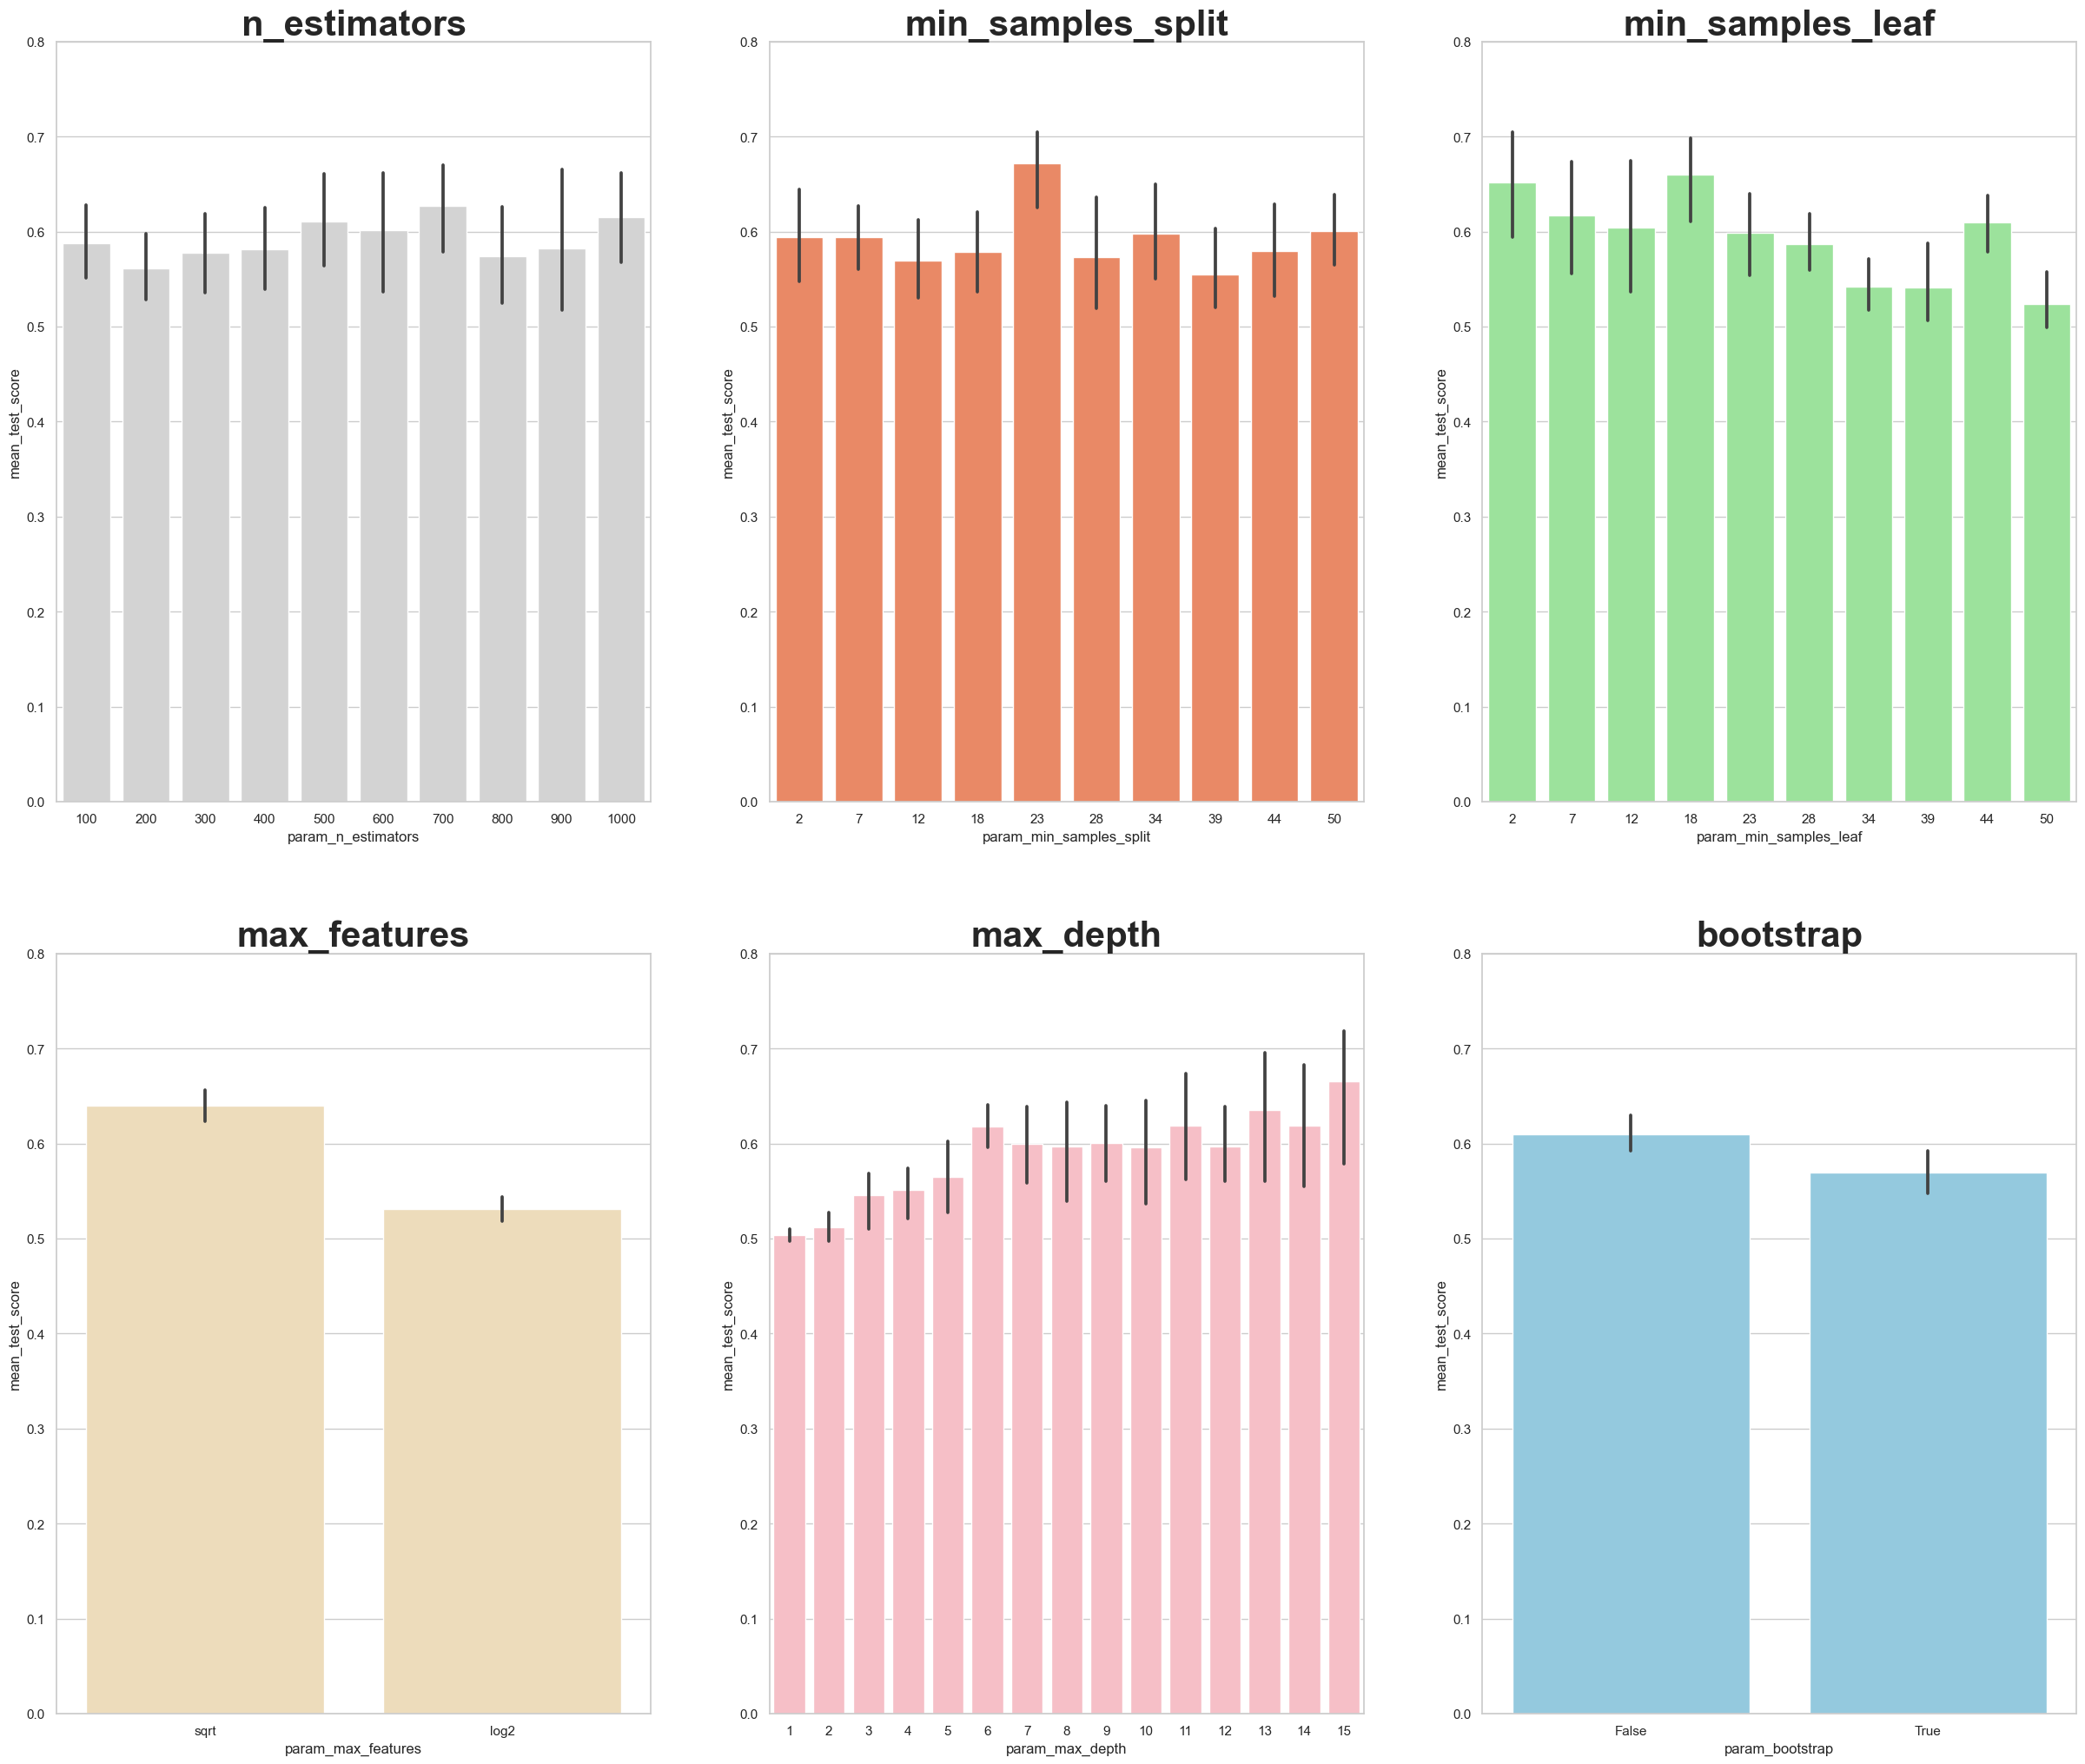

In [155]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot( data=rs_df,x='param_n_estimators', y='mean_test_score', ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([0,0.8])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([0,0.8])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([0,0.8])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([0,0.8])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([0,0.8])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([0,0.8])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()


Далее уже из вручную выбранных значений, с помощью GridSearchCV находим наилучшую комбинацию гиперпараметров для нашей модели

In [156]:
from sklearn.model_selection import GridSearchCV
n_estimators = [500,700]
min_samples_split = [2,23]
min_samples_leaf = [2,18]
max_features = ['sqrt']
max_depth = [6,15]
bootstrap = [True]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(Train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 500}

In [157]:
y_pred = gs.best_estimator_.predict(Test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

Dopamine D1 receptor       0.96      0.85      0.90       130
Dopamine D2 receptor       0.72      0.87      0.79       420
Dopamine D3 receptor       0.66      0.47      0.55       197
Dopamine D4 receptor       0.92      0.75      0.83       101

            accuracy                           0.76       848
           macro avg       0.81      0.74      0.77       848
        weighted avg       0.77      0.76      0.76       848



Результаты неплохие, мы в 0.76 случаев определяем правильный класс, при этом имея достоный F1-Score почти для всех классов

# Попробуем понизить размерность с помощью PCA

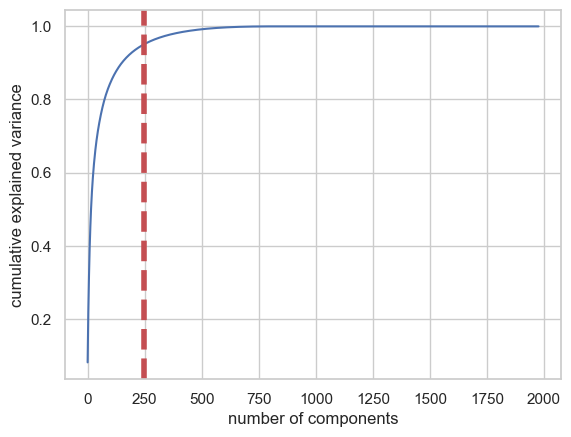

None

,Cumulative Variance Ratio,Explained Variance Ratio
240,0.948442,0.000362
241,0.948799,0.000357
242,0.949154,0.000355
243,0.949504,0.000351
244,0.949853,0.000348
245,0.950199,0.000347
246,0.950545,0.000345
247,0.950886,0.000342
248,0.951224,0.000338
249,0.951561,0.000337


In [158]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=1977)
pca_test.fit(Train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=246, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.iloc[240:250])

Взяв 246 главных компонент мы объясняем 95% дисперсии данных, попробуем посмотреть на результаты предсказаний

In [159]:
pca = PCA(n_components=246)
pca.fit(Train)
Train_pca = pca.transform(Train)
pca.fit(Test)
Test_pca = pca.transform(Test)

In [160]:
rfc_3.fit(Train_pca,y_train)
y_pred = gs.best_estimator_.predict(Test_pca)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

Dopamine D1 receptor       1.00      0.18      0.30       130
Dopamine D2 receptor       0.51      0.99      0.67       420
Dopamine D3 receptor       0.46      0.03      0.06       197
Dopamine D4 receptor       0.00      0.00      0.00       101

            accuracy                           0.52       848
           macro avg       0.49      0.30      0.26       848
        weighted avg       0.51      0.52      0.39       848



Что было понятно с самого начала, применение PCA для отпечатков не приводит к хорошим результам, так поступать не стоит!

# Проверим GradientBoostingClassifier

In [161]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = ensemble.GradientBoostingClassifier(random_state = 0)
n_estimators = [500]
min_samples_split = [6]
min_samples_leaf = [10]
max_depth = [10]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gs = GridSearchCV(gbc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(Train, y_train)
gbr = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 6,
 'n_estimators': 500}

In [162]:
y_pred = gs.best_estimator_.predict(Test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                      precision    recall  f1-score   support

Dopamine D1 receptor       0.86      0.87      0.86       130
Dopamine D2 receptor       0.71      0.77      0.74       420
Dopamine D3 receptor       0.53      0.46      0.49       197
Dopamine D4 receptor       0.91      0.80      0.85       101

            accuracy                           0.72       848
           macro avg       0.75      0.72      0.74       848
        weighted avg       0.71      0.72      0.71       848



Градиентый бустинг оказался чуть менее точным, но зато с лучшим средним F1-score...

# 4 Часть: классификация с помощью дескрипторов RDKit

In [204]:
df_desc2 = filtered_df['Target Name']
df_desc2 = df_desc2.reset_index()
df_desc2

,index,Target Name
0,0,Dopamine D1 receptor
1,1,Dopamine D1 receptor
2,2,Dopamine D1 receptor
3,3,Dopamine D1 receptor
4,4,Dopamine D1 receptor
...,...,...
2853,3120,Dopamine D5 receptor
2854,3121,Dopamine D5 receptor
2855,3122,Dopamine D5 receptor
2856,3123,Dopamine D5 receptor


In [205]:
from sklearn.preprocessing import LabelEncoder
df_desc2 = df_desc2[df_desc2['Target Name'] !='Dopamine D5 receptor']
le = LabelEncoder()
le.fit(df_desc2['Target Name'])
df_desc2['Target Name'] = le.transform(df_desc2['Target Name'])
df_desc2['Target Name'].value_counts()

C:\Users\Max\AppData\Local\Temp\ipykernel_1468\2530055688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_desc2['Target Name'] = le.transform(df_desc2['Target Name'])


Target Name
1    1400
2     657
0     432
3     336
Name: count, dtype: int64

In [206]:
## from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_with_descriptors)
scaled_df2 = pd.DataFrame(scaler.transform(df_with_descriptors), columns = df_with_descriptors.columns)
scaled_df2['Target Name'] = df_desc2['Target Name']
scaled_df2 = scaled_df2.dropna()
scaled_df2

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Target Name
0,-1.172006,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
1,-1.357800,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
2,-1.245900,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
3,-1.078121,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
4,-1.201573,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,0.819041,0.819041,1.559029,-0.177490,1.365313,1.237331,-0.575171,-0.632649,-0.574527,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0
2821,0.509486,0.509486,-1.364488,0.912053,1.392462,0.343869,-0.452574,-0.445345,-0.451632,-0.502386,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,7.906397,0.0,-0.26917,3.0
2822,0.652278,0.652278,-1.446031,0.583235,0.824286,0.063165,-0.355651,-0.351510,-0.354712,-0.408268,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0
2823,0.855980,0.855980,2.108231,-1.497997,1.029807,1.550677,-0.372824,-0.464252,-0.371346,-0.172973,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,3.63584,3.0


In [207]:
from sklearn.ensemble import IsolationForest
data_imputed=scaled_df2
iforest = IsolationForest(n_estimators = 500, random_state=0,
    max_samples = "auto", 
    contamination= 0.05 #зададим сами процент потенциальных аномалий в БД
                          #Иначе алгоритм попытается определить это самостоятельно, иногда удаляя слишком много данных
    )
iforest_fit = iforest.fit(data_imputed)
predictions = iforest_fit.predict(data_imputed)

data_imputed['is_anomaly_prediction'] = predictions
data_imputed = data_imputed[data_imputed.is_anomaly_prediction != -1]
data_imputed = data_imputed.drop(columns = ['is_anomaly_prediction'])
data_imputed.describe()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Target Name
count,2669.000000,2669.000000,2669.000000,2669.000000,2669.000000,2669.000000,2669.000000,2669.000000,2669.000000,2669.000000,...,2669.000000,2669.000000,2669.000000,2669.0,2669.000000,2669.0,2669.000000,2669.0,2669.000000,2669.000000
mean,-0.044967,-0.044967,0.009525,0.061984,0.112718,0.012848,-0.118989,-0.117641,-0.119163,-0.121805,...,0.004402,0.002964,-0.025598,0.0,-0.072097,0.0,0.008956,0.0,-0.052631,1.309105
std,1.000903,1.000903,0.967638,0.968480,0.910269,0.989703,0.777446,0.786883,0.776687,0.742446,...,1.034853,1.034931,0.880847,0.0,0.816195,0.0,1.034408,0.0,0.893865,0.880402
min,-1.699206,-1.699206,-1.477047,-4.095284,-2.142916,-2.103161,-2.178794,-2.133671,-2.178828,-2.196514,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,0.000000
25%,-1.141985,-1.141985,-0.809983,-0.491168,-0.548128,-0.494395,-0.558377,-0.576789,-0.557026,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,1.000000
50%,0.347816,0.347816,-0.074701,-0.021335,0.037589,-0.177888,-0.020964,-0.032565,-0.019207,0.015264,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,1.000000
75%,0.809476,0.809476,0.479102,0.489216,0.857742,0.358005,0.390950,0.388694,0.386706,0.344677,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.269170,2.000000
max,2.301640,2.301640,5.546643,6.109313,1.758402,3.941710,2.711533,2.860174,2.691306,2.085864,...,16.087827,23.887235,8.853750,0.0,4.373510,0.0,7.906397,0.0,3.635840,3.000000


# Посмотрим на кореляцию наших признаков

<Axes: title={'center': 'Spearman Correlation Matrix'}>

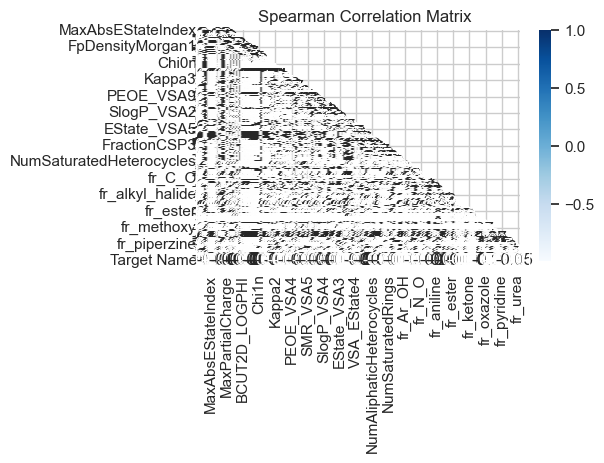

In [208]:
sp_corr_mat = data_imputed.corr(method = 'spearman')
fig = plt.figure(figsize=(5, 3))
plt.title("Spearman Correlation Matrix")
mask = np.triu(np.ones_like(sp_corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(sp_corr_mat,
           mask = mask,
           cmap="Blues", annot=True, center=0, fmt='.2f')


Выше мы можем на глаз видеть много различных признаков, которые сильно коррелируют. Но при таком количестве признаков на глаз найти все пары и убрать ненужные фичи практически невозможно

Поэтому воспользуемся функцией:
с ее помощью мы можем получить список списков пар всех фичей, корреляция которых превышает 0.6

In [209]:
def print_highly_correlated(df, features, threshold=0.6):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df[features].corr(method = 'spearman') # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    g = []
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            g.append([corr_df.columns[j],corr_df.index[i]])
            print ("%s and %s = %.3f" % (corr_df.index[i], corr_df.columns[j], v))
    return(g)

In [210]:
high_cor_pairs = print_highly_correlated(df=data_imputed, features=data_imputed.columns)

MaxAbsEStateIndex and MaxEStateIndex = 1.000
NumAromaticCarbocycles and fr_benzene = 1.000
fr_Ar_NH and fr_Nhpyrrole = 1.000
fr_COO and fr_COO2 = 1.000
fr_ketone and fr_ketone_Topliss = 1.000
fr_nitro and fr_nitro_arom = 1.000
MolWt and ExactMolWt = 1.000
MaxPartialCharge and MinAbsPartialCharge = 0.999
Chi0n and Chi1n = 0.999
MolWt and HeavyAtomMolWt = 0.998
HeavyAtomMolWt and ExactMolWt = 0.997
fr_phenol and fr_phenol_noOrthoHbond = 0.997
MinPartialCharge and MaxAbsPartialCharge = -0.996
Chi0 and Chi1n = 0.995
Chi0 and Chi0n = 0.995
MolWt and Chi0v = 0.994
ExactMolWt and Chi0v = 0.994
HeavyAtomMolWt and Chi0v = 0.992
Chi0 and Chi1 = 0.991
Chi0v and Chi1v = 0.990
NumValenceElectrons and HeavyAtomCount = 0.990
NumValenceElectrons and LabuteASA = 0.990
LabuteASA and MolMR = 0.988
fr_C_O and fr_C_O_noCOO = 0.986
Chi0v and MolMR = 0.984
Chi1 and Chi1n = 0.984
fr_Ar_OH and fr_phenol = 0.982
Chi1 and EState_VSA1 = 0.982
NHOHCount and NumHDonors = 0.981
NumValenceElectrons and MolMR = 0.981


Итого у нас есть 700+ пар высокоскоррелированных признаков, сейчас нам нужно начать удалять признаки, но так чтобы не удалить лишние. Так как есть пересечения между различными признаками

In [211]:
def print_highly_correlated2(df, features, threshold=0.6):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df[features].corr(method = 'spearman') # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    g = []
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            g.append([corr_df.columns[j],corr_df.index[i]])
    return(g)

In [212]:
df_drop = data_imputed.drop(high_cor_pairs[0][0],axis=1)
df_drop

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Target Name
0,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
1,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
2,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
3,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,0.0,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
4,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,-1.393456,-0.186274,0.613641,1.581450,0.190839,-0.392810,-0.343883,-0.399323,-0.643564,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0
2820,0.819041,1.559029,-0.177490,1.365313,1.237331,-0.575171,-0.632649,-0.574527,-0.549445,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0
2821,0.509486,-1.364488,0.912053,1.392462,0.343869,-0.452574,-0.445345,-0.451632,-0.502386,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,7.906397,0.0,-0.26917,3.0
2822,0.652278,-1.446031,0.583235,0.824286,0.063165,-0.355651,-0.351510,-0.354712,-0.408268,0.0,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0


In [213]:
while high_cor_pairs != []:
    high_cor_pairs = print_highly_correlated2(df=df_drop, features=df_drop.columns)
    if high_cor_pairs == []:
        break
    df_drop = df_drop.drop(high_cor_pairs[0][0],axis=1)


There are no highly correlated features with correlation above 0.6


Теперь в нашем датасете нет ни одной пары признаков корреляция спирмана для которых >=0.6

In [214]:
df_drop

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Target Name
0,-1.172006,1.311432,0.648877,0.826533,0.102623,0.0,0.332571,-0.806255,0.706162,-0.589596,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
1,-1.357800,1.172134,0.863199,0.382541,0.993119,0.0,0.332571,-0.806255,2.389627,-0.589620,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
2,-1.245900,1.739495,-0.346924,-0.159567,1.023139,0.0,0.332571,-0.806255,1.225505,-0.589616,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
3,-1.078121,1.453965,-0.410879,-0.641016,1.672524,0.0,0.332571,-0.806255,0.882210,-0.589536,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
4,-1.201573,1.188559,0.822963,0.838187,0.192811,0.0,0.332571,-0.806255,0.328914,-0.589614,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,-1.393456,-0.186274,0.613641,1.581450,0.190839,0.0,-1.927497,0.894663,1.170290,0.909237,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,3.0
2820,0.819041,1.559029,-0.177490,1.365313,1.237331,0.0,-0.398999,1.670179,1.170290,0.646479,...,0.0,11.353814,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,3.0
2821,0.509486,-1.364488,0.912053,1.392462,0.343869,0.0,1.058946,-0.219782,2.114551,0.643869,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,7.906397,0.0,-0.26917,3.0
2822,0.652278,-1.446031,0.583235,0.824286,0.063165,0.0,1.198227,-0.211653,1.292991,0.646470,...,0.0,11.353814,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,3.0


<Axes: title={'center': 'Spearman Correlation Matrix'}>

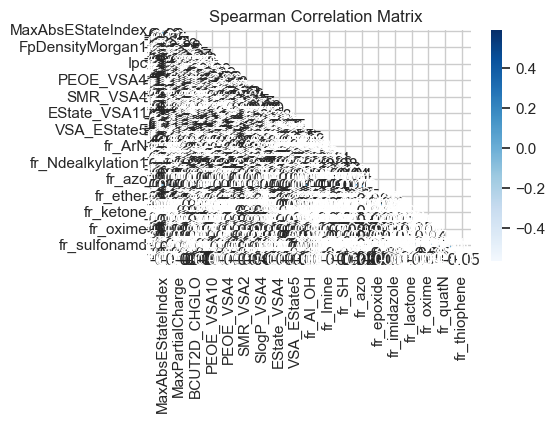

In [215]:
sp_corr_mat = df_drop.corr(method = 'spearman')
fig = plt.figure(figsize=(5, 3))
plt.title("Spearman Correlation Matrix")
mask = np.triu(np.ones_like(sp_corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(sp_corr_mat,
           mask = mask,
           cmap="Blues", annot=True, center=0, fmt='.2f')


Как видим теперь максимум на графике соответсвует 0.6, чего мы и хотели добиться :)
цифра 0.6 появилась постфактум, потому что изначально я брал значение в 0.85, но разница между моделями была еще меньше..

Таким образом мы понизили размерность с 200+ до 112

# Battle двух датасетов:

Дата сет со всеми посчитанными дескрипторами RDKit (**df1**) vs Очищенный от лишних фичей (по критерию корреляции Спирмана) (**df2**) 

In [216]:
df1 = data_imputed
df1

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Target Name
0,-1.172006,-1.172006,1.311432,0.648877,0.826533,0.102623,-0.620305,-0.614632,-0.618960,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
1,-1.357800,-1.357800,1.172134,0.863199,0.382541,0.993119,-1.430091,-1.439751,-1.429441,-1.349450,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
2,-1.245900,-1.245900,1.739495,-0.346924,-0.159567,1.023139,-0.936747,-0.989606,-0.935694,-0.784741,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
3,-1.078121,-1.078121,1.453965,-0.410879,-0.641016,1.672524,-0.619918,-0.651997,-0.618640,-0.502386,...,-0.062159,-0.041863,8.853750,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
4,-1.201573,-1.201573,1.188559,0.822963,0.838187,0.192811,-0.884316,-0.877070,-0.883265,-0.831800,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,-1.393456,-1.393456,-0.186274,0.613641,1.581450,0.190839,-0.392810,-0.343883,-0.399323,-0.643564,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0
2820,0.819041,0.819041,1.559029,-0.177490,1.365313,1.237331,-0.575171,-0.632649,-0.574527,-0.549445,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0
2821,0.509486,0.509486,-1.364488,0.912053,1.392462,0.343869,-0.452574,-0.445345,-0.451632,-0.502386,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,7.906397,0.0,-0.26917,3.0
2822,0.652278,0.652278,-1.446031,0.583235,0.824286,0.063165,-0.355651,-0.351510,-0.354712,-0.408268,...,-0.062159,-0.041863,-0.112946,0.0,-0.221891,0.0,-0.126480,0.0,-0.26917,3.0


In [217]:
df2 = data_imputed[df_drop.columns]
df2

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_tetrazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Target Name
0,-1.172006,1.311432,0.648877,0.826533,0.102623,0.0,0.332571,-0.806255,0.706162,-0.589596,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
1,-1.357800,1.172134,0.863199,0.382541,0.993119,0.0,0.332571,-0.806255,2.389627,-0.589620,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
2,-1.245900,1.739495,-0.346924,-0.159567,1.023139,0.0,0.332571,-0.806255,1.225505,-0.589616,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
3,-1.078121,1.453965,-0.410879,-0.641016,1.672524,0.0,0.332571,-0.806255,0.882210,-0.589536,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
4,-1.201573,1.188559,0.822963,0.838187,0.192811,0.0,0.332571,-0.806255,0.328914,-0.589614,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,-1.393456,-0.186274,0.613641,1.581450,0.190839,0.0,-1.927497,0.894663,1.170290,0.909237,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,3.0
2820,0.819041,1.559029,-0.177490,1.365313,1.237331,0.0,-0.398999,1.670179,1.170290,0.646479,...,0.0,11.353814,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,3.0
2821,0.509486,-1.364488,0.912053,1.392462,0.343869,0.0,1.058946,-0.219782,2.114551,0.643869,...,0.0,-0.088076,-0.062159,-0.041863,0.0,0.0,7.906397,0.0,-0.26917,3.0
2822,0.652278,-1.446031,0.583235,0.824286,0.063165,0.0,1.198227,-0.211653,1.292991,0.646470,...,0.0,11.353814,-0.062159,-0.041863,0.0,0.0,-0.126480,0.0,-0.26917,3.0


In [218]:
X = df1.drop(['Target Name'],axis=1)
y = df1['Target Name']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

In [219]:
X_traindf2 = X_train[df_drop.drop(['Target Name'],axis=1).columns]
X_testdf2 =  X_test[df_drop.drop(['Target Name'],axis=1).columns]

# Проведем оптимизацию гиперпараметров для RFC для подготовиленного датасета


Сначала воспользуемся RandomizedSearchCV а потом уже GridSearchem

In [220]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_traindf2, y_train)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 1000,
 'min_samples_split': 12,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

После чего строю графики для каждого параметра, где можно будет визуально увидеть лучшие значения

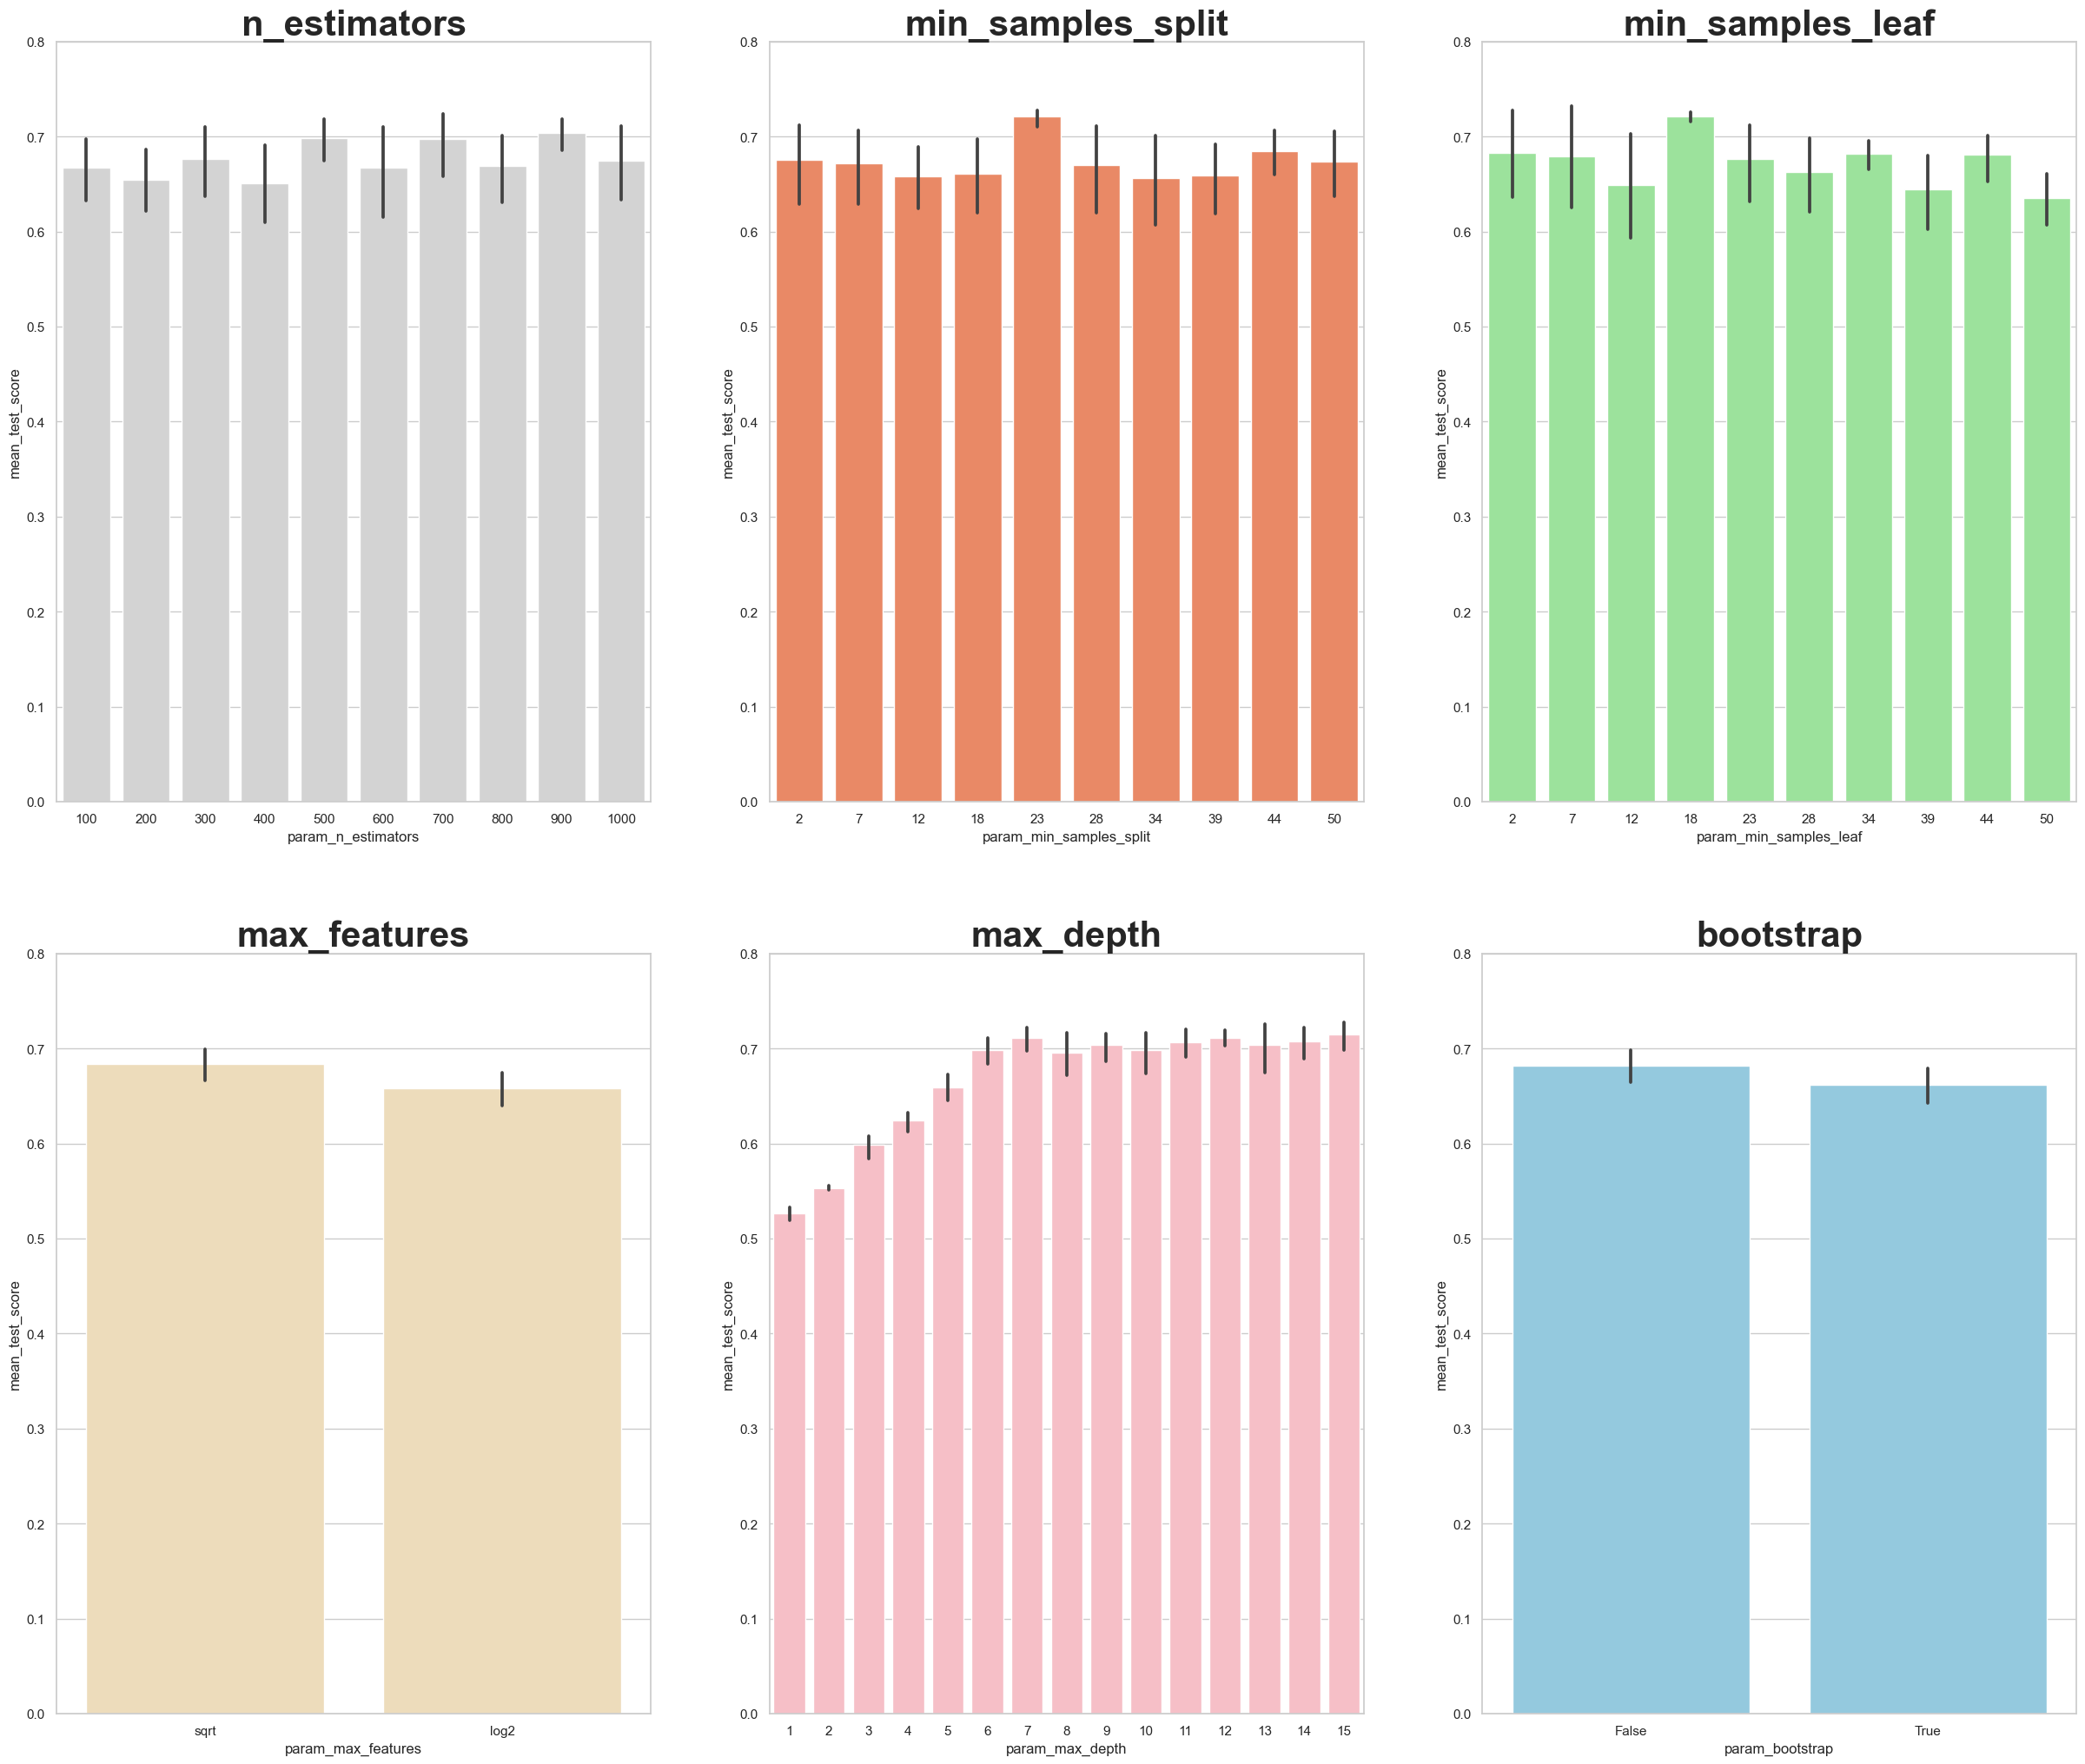

In [221]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot( data=rs_df,x='param_n_estimators', y='mean_test_score', ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([0,0.8])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([0,0.8])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([0,0.8])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([0,0.8])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([0,0.8])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([0,0.8])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()


Далее уже из вручную выбранных значений, с помощью GridSearchCV находим наилучшую комбинацию гиперпараметров для нашей модели

In [222]:
from sklearn.model_selection import GridSearchCV
n_estimators = [500,900]
min_samples_split = [2,23]
min_samples_leaf = [2,18]
max_features = ['sqrt']
max_depth = [7,12]
bootstrap = [True,False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_traindf2, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


{'bootstrap': False,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 500}

In [223]:
y_pred = gs.best_estimator_.predict(X_testdf2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85       130
         1.0       0.71      0.81      0.76       400
         2.0       0.61      0.54      0.57       185
         3.0       0.95      0.72      0.82        86

    accuracy                           0.74       801
   macro avg       0.80      0.72      0.75       801
weighted avg       0.75      0.74      0.74       801



Теперь посчитаем тоже самое для датасета без отфильтрованных фичей

In [226]:
rfc_3.fit(X_train,y_train)
y_pred = rfc_3.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       130
         1.0       0.72      0.81      0.76       400
         2.0       0.60      0.52      0.56       185
         3.0       0.92      0.76      0.83        86

    accuracy                           0.74       801
   macro avg       0.78      0.73      0.75       801
weighted avg       0.74      0.74      0.74       801



Разницы в выборе двух датасетов для нашей задачи классификации практически не оказалось, что отлично, ведь мы сократили размерность с 200+ до 112 с сохранением всех метрик!

# Попробуем понизить размерность с помощью PCA

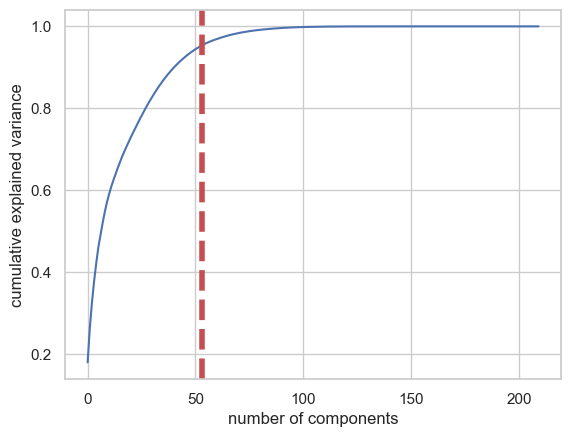

None

,Cumulative Variance Ratio,Explained Variance Ratio
50,0.944332,0.003496
51,0.947559,0.003227
52,0.950728,0.003168
53,0.953640,0.002912
54,0.956416,0.002775


In [233]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=210)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=53, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.iloc[50:55])

Взяв 53 главных компонент мы объясняем 95% дисперсии данных, но для сравнения с нашим методом понижения размерности путем удаление высокоскоррелированных признаков, возьмем нашу конечную размерность = 112

In [236]:
pca = PCA(n_components=112)
pca.fit(X_train)
Train_pca = pca.transform(X_train)
pca.fit(X_test)
Test_pca = pca.transform(X_test)

In [237]:
rfc_3.fit(Train_pca,y_train)
y_pred = gs.best_estimator_.predict(Test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.29      0.45       130
         1.0       0.54      0.96      0.69       400
         2.0       0.59      0.12      0.20       185
         3.0       0.38      0.03      0.06        86

    accuracy                           0.56       801
   macro avg       0.61      0.35      0.35       801
weighted avg       0.60      0.56      0.47       801



И снова PCA показывает результаты ощутимо хуже по всем метрикам! То есть наш метод понижения размерности гораздо эффективнее!

# Выводы по задаче классификации:

Используя отпечатки моргана r = 2, битность = 2048 и **RFC** в качестве модели мы получаем:  
-------------------------------**F1-score**  
Dopamine D1 receptor -          0.90      
Dopamine D2 receptor  -         0.79      
Dopamine D3 receptor   -      0.55       
Dopamine D4 receptor    -        0.83       
 ----------------------------**accuracy 0.76**       
 
Используя те же отпечатки и **RFC** в качестве модели, но с предварительным понижением размерности с помощью **PCA** мы получаем:  
-------------------------------**F1-score**  
Dopamine D1 receptor -          0.30      
Dopamine D2 receptor  -         0.67      
Dopamine D3 receptor   -      0.06       
Dopamine D4 receptor    -        0.00       
 ----------------------------**accuracy 0.52**      
 
Используя те же отпечатки и **GBC** в качестве модели мы получаем:  
-------------------------------**F1-score**  
Dopamine D1 receptor -          0.86      
Dopamine D2 receptor  -         0.74      
Dopamine D3 receptor   -      0.49       
Dopamine D4 receptor    -        0.85       
 ----------------------------**accuracy 0.72**      


Используя все дескрипторы полученные в **RDKit** - модель **RFC**:  
-------------------------------**F1-score**  
Dopamine D1 receptor - 0.86  
Dopamine D2 receptor - 0.76  
Dopamine D3 receptor - 0.56  
Dopamine D4 receptor - 0.83  
----------------------------**accuracy 0.74**  

Используя нескоррелированные дескрипторы полученные в **RDKit** - модель **RFC**:  
-------------------------------**F1-score**  
Dopamine D1 receptor - 0.85  
Dopamine D2 receptor - 0.76  
Dopamine D3 receptor - 0.57  
Dopamine D4 receptor - 0.82  
----------------------------**accuracy 0.74**  

Используя PCA в качестве алгоритма понижения размерности дескрипторов в **RDKit** - модель **RFC**:  
-------------------------------**F1-score**  
Dopamine D1 receptor - 0.45  
Dopamine D2 receptor - 0.69  
Dopamine D3 receptor - 0.20  
Dopamine D4 receptor - 0.06  
----------------------------**accuracy 0.56**  

Таким образом можно легко увидеть, что отпечатки моргана дают наилучший результат для предсказания класса лиганда дофаминового рецептора, исходя из чего можно сделать вывод, что химическая структура напрямую определяет класс лиганда, чего не было в случае решения задачи регрессии по предсказанию концентрации pEC50!   

Дескрипторы RDKit также дают схожую точность, наилучшим решением является использование не всех дескрипторов, а только те, которые не будут являться высокоскоррелированными друг с другом и моделью выбрать RFC

Еще один простой вывод, PCA не волшебная вещь, которая не позволяет магическим образом понизить размерность без потери качества модели, особенно когда мы говорим о понижении размерности таких систем, как отпечатки моргана... Во всех примерах в данной работе использование PCA приводило к сущетсвенному ухудшению работы модели. В то время как метод понижения размености путем анализа корреляции Спирмана для всех признаков с последующим удалением высокоскоррелированных, позволяет не просто понизить размерность, но даже не потерять эффективности работы модели! (а в случае больших объемов сетов, я уверен, что эффективность модели даже вырастет!) Так что Data-Preproccecing - наше все!

# The End